# Imports and functions

In [35]:
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
from matplotlib.lines import Line2D 
from scipy.stats import kendalltau, spearmanr
import pandas as pd
import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 600 
mpl.rcParams['figure.dpi'] = 100
warnings.simplefilter(action='ignore', category=FutureWarning)

In [36]:
def rdmmaker(rdm):
    temp=[]
    for i in rdm:
        temp2=[]
        for j in rdm:
            temp2.append(np.corrcoef(np.array(i),np.array(j))[0,1])
        temp.append(temp2)
    return np.array(temp)

In [37]:
def rdmmakerspear(rdm):
    temp=[]
    for i in rdm:
        temp2=[]
        for j in rdm:
            temp2.append(spearmanr(np.array(i),np.array(j))[0])
        temp.append(temp2)
    return np.array(temp)

In [38]:
def rank_values(values):
    sorted_values = sorted(values)
    ranks = [sorted_values.index(x) + 1 for x in values]
    ranks = -1*np.array(ranks) +len(ranks)+1
    return ranks

In [39]:
def scaler(x,min,max):
    if type(min)==list:
        min = np.max(min)
    return (x-min)/(max-min)

In [40]:
def list_files_recursive(path='.',NSD=True):
    temp=[]
    if NSD:
        for root, dirs, files in os.walk(path):
            for file in files:
                
                if file.startswith('NSD'):
                    if 'SRP' in file and '1000' in file:
                        if 'minandmax' not in root and 'catpreds' not in root:
                            temp.append(os.path.join(root, file))
                        
    else:
        for root, dirs, files in os.walk(path):
            for file in files:

                temp.append(os.path.join(root, file))
    return temp

In [41]:
METRICS=['LinearPredictivity','PLSreg','VERSA','RSA','CKA','PairwiseMatching','Procrustes','SoftMatching','ReverseLinearPredictivity']
METRICNAMES={'LinearPredictivity':'LP','ReverseLinearPredictivity':'rLP','PLSreg':'PLS','PairwiseMatching':'1to1','SoftMatching':'SM','RSA':'RSA','VERSA':'veRSA','CKA':'CKA','Procrustes':'LSM'}
METRICCOLORS={'LinearPredictivity':(220,5,12),'ReverseLinearPredictivity':(209,187,215),'PLSreg':(232,96,28),'PairwiseMatching':(246,193,65),'SoftMatching':(136,46,114),'RSA':(25,101,176),'VERSA':(123,175,222),'CKA':(78,178,101),'Procrustes':(202,224,171)}
for i in list(METRICCOLORS.keys()):
    METRICCOLORS[i]=np.array(METRICCOLORS[i])/255
DATASETS=['NSD_V1','Monkey_V1','NSD_V2','InanimateObjects_EarlyV','ObjectOrientation_EarlyV','NSD_V4','InanimateObjects_pOTC','ObjectOrientation_pOTC','NSD_VVS','Monkey_IT','InanimateObjects_aOTC','ObjectOrientation_aOTC']
DOWNSCALE=['None','SRP']
NSDSHARED=['1000','515']
NSDAREAS=['V1','V2','V4','VVS']
LEGENDLOC=(-1.01,.1)
MARKERSIZE = 5

cmapsns=sns.diverging_palette(250, 30, l=65, center="dark", as_cmap=True)




# Fig 1: intro

In [42]:
x=np.random.poisson(10,size=(50,78))


In [43]:
y=np.random.normal(0,.5,size=(50,100))

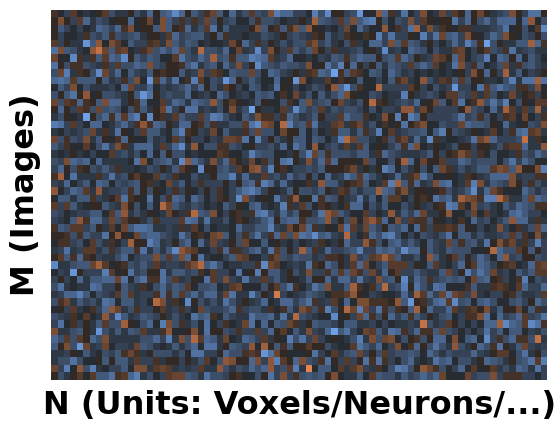

In [44]:
sns.heatmap(x, cbar=False, xticklabels=False, yticklabels=False,cmap=cmapsns)
plt.ylabel('M (Images)', fontweight='bold', fontsize=23)
plt.xlabel('N (Units: Voxels/Neurons/...)', fontweight='bold', fontsize=23)
plt.show()

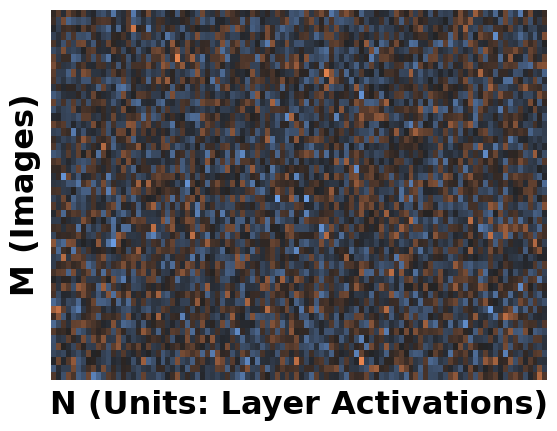

In [45]:
sns.heatmap(y, cbar=False, xticklabels=False, yticklabels=False,cmap=cmapsns)
plt.ylabel('M (Images)', fontweight='bold', fontsize=23)
plt.xlabel('N (Units: Layer Activations)', fontweight='bold', fontsize=23)
plt.show()

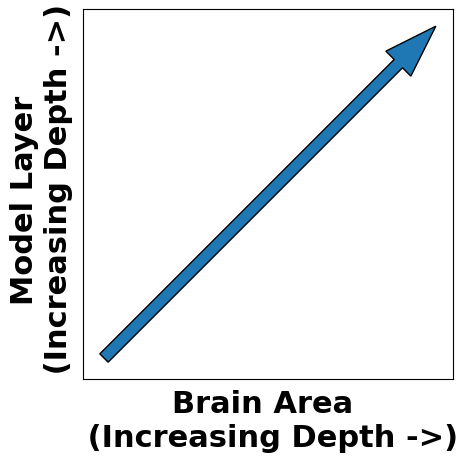

In [46]:
plt.arrow(0,0,1,1,width=.04)
plt.xticks([])
plt.yticks([])
plt.ylabel('Model Layer \n (Increasing Depth ->)', fontweight='bold', fontsize=22)
plt.xlabel('Brain Area \n (Increasing Depth ->)', fontweight='bold', fontsize=22)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

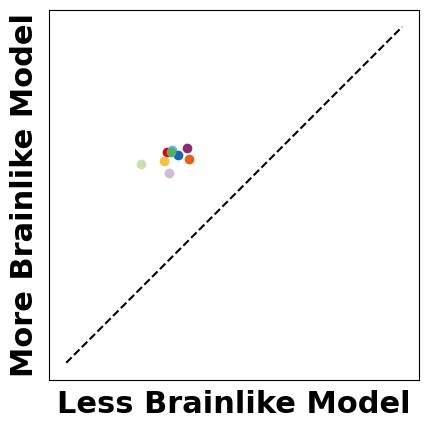

In [47]:
for i in METRICS:
    plt.scatter(0.3+np.random.normal(0,0.04),0.6+np.random.normal(0,0.04),color=METRICCOLORS[i])
plt.plot([0,1],[0,1],color='black',ls='--')

plt.xticks([])
plt.yticks([])
plt.ylabel('More Brainlike Model', fontweight='bold', fontsize=22)
plt.xlabel('Less Brainlike Model', fontweight='bold', fontsize=22)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

# Figure 2: Hierarchical Correspondence

In [48]:
paths=['results/alexnet/']
paths.append('results/generic_imagenet/resnet_resnet50/')
paths.append('results/generic_imagenet/VGG_vgg16_bn/')
paths.append('results/generic_imagenet/VIT_h14/')
alldfssaved={}
tempindex=0
for path in paths:
    scores={}

    for file_name in os.listdir(path):
        if file_name.__contains__('NSD'):
            scores[file_name[:-4]]=np.load(path+file_name,allow_pickle=True)[()]
            for l in METRICS:
                scores[file_name[:-4]][l]=scores[file_name[:-4]][l].groupby('Layer', sort=False).mean()
                scores[file_name[:-4]][l]=np.array(list(scores[file_name[:-4]][l]['Score']))
    alldfs={}
    if path=='results/alexnet/':
        iscale= 'None'
    else:
        iscale= 'SRP'
    ishared='1000'
    tempdf=pd.DataFrame(columns = ['Metric','BrainArea', 'Layer'])
    for imetric in METRICS:
        if imetric=='Procrustes' or imetric=='SoftMatching':
            const=-1
        else:
            const=1
        for iarea in NSDAREAS:
            all_scores=np.array(list(scores['NSD_{}_{}_{}'.format(iarea,ishared,iscale)][imetric]))
            layer=np.argmax(const*all_scores)/len(all_scores)
            tempdf.loc[len(tempdf)] = {'Metric':imetric,'BrainArea': iarea, 'Layer': layer}
    alldfs["{}_{}".format(iscale,ishared)]=tempdf     
    name=['Alexnet','ResNet50','VGG16','VITh14']
    alldfssaved[name[tempindex]]=alldfs[f'{iscale}_1000']
    tempindex+=1



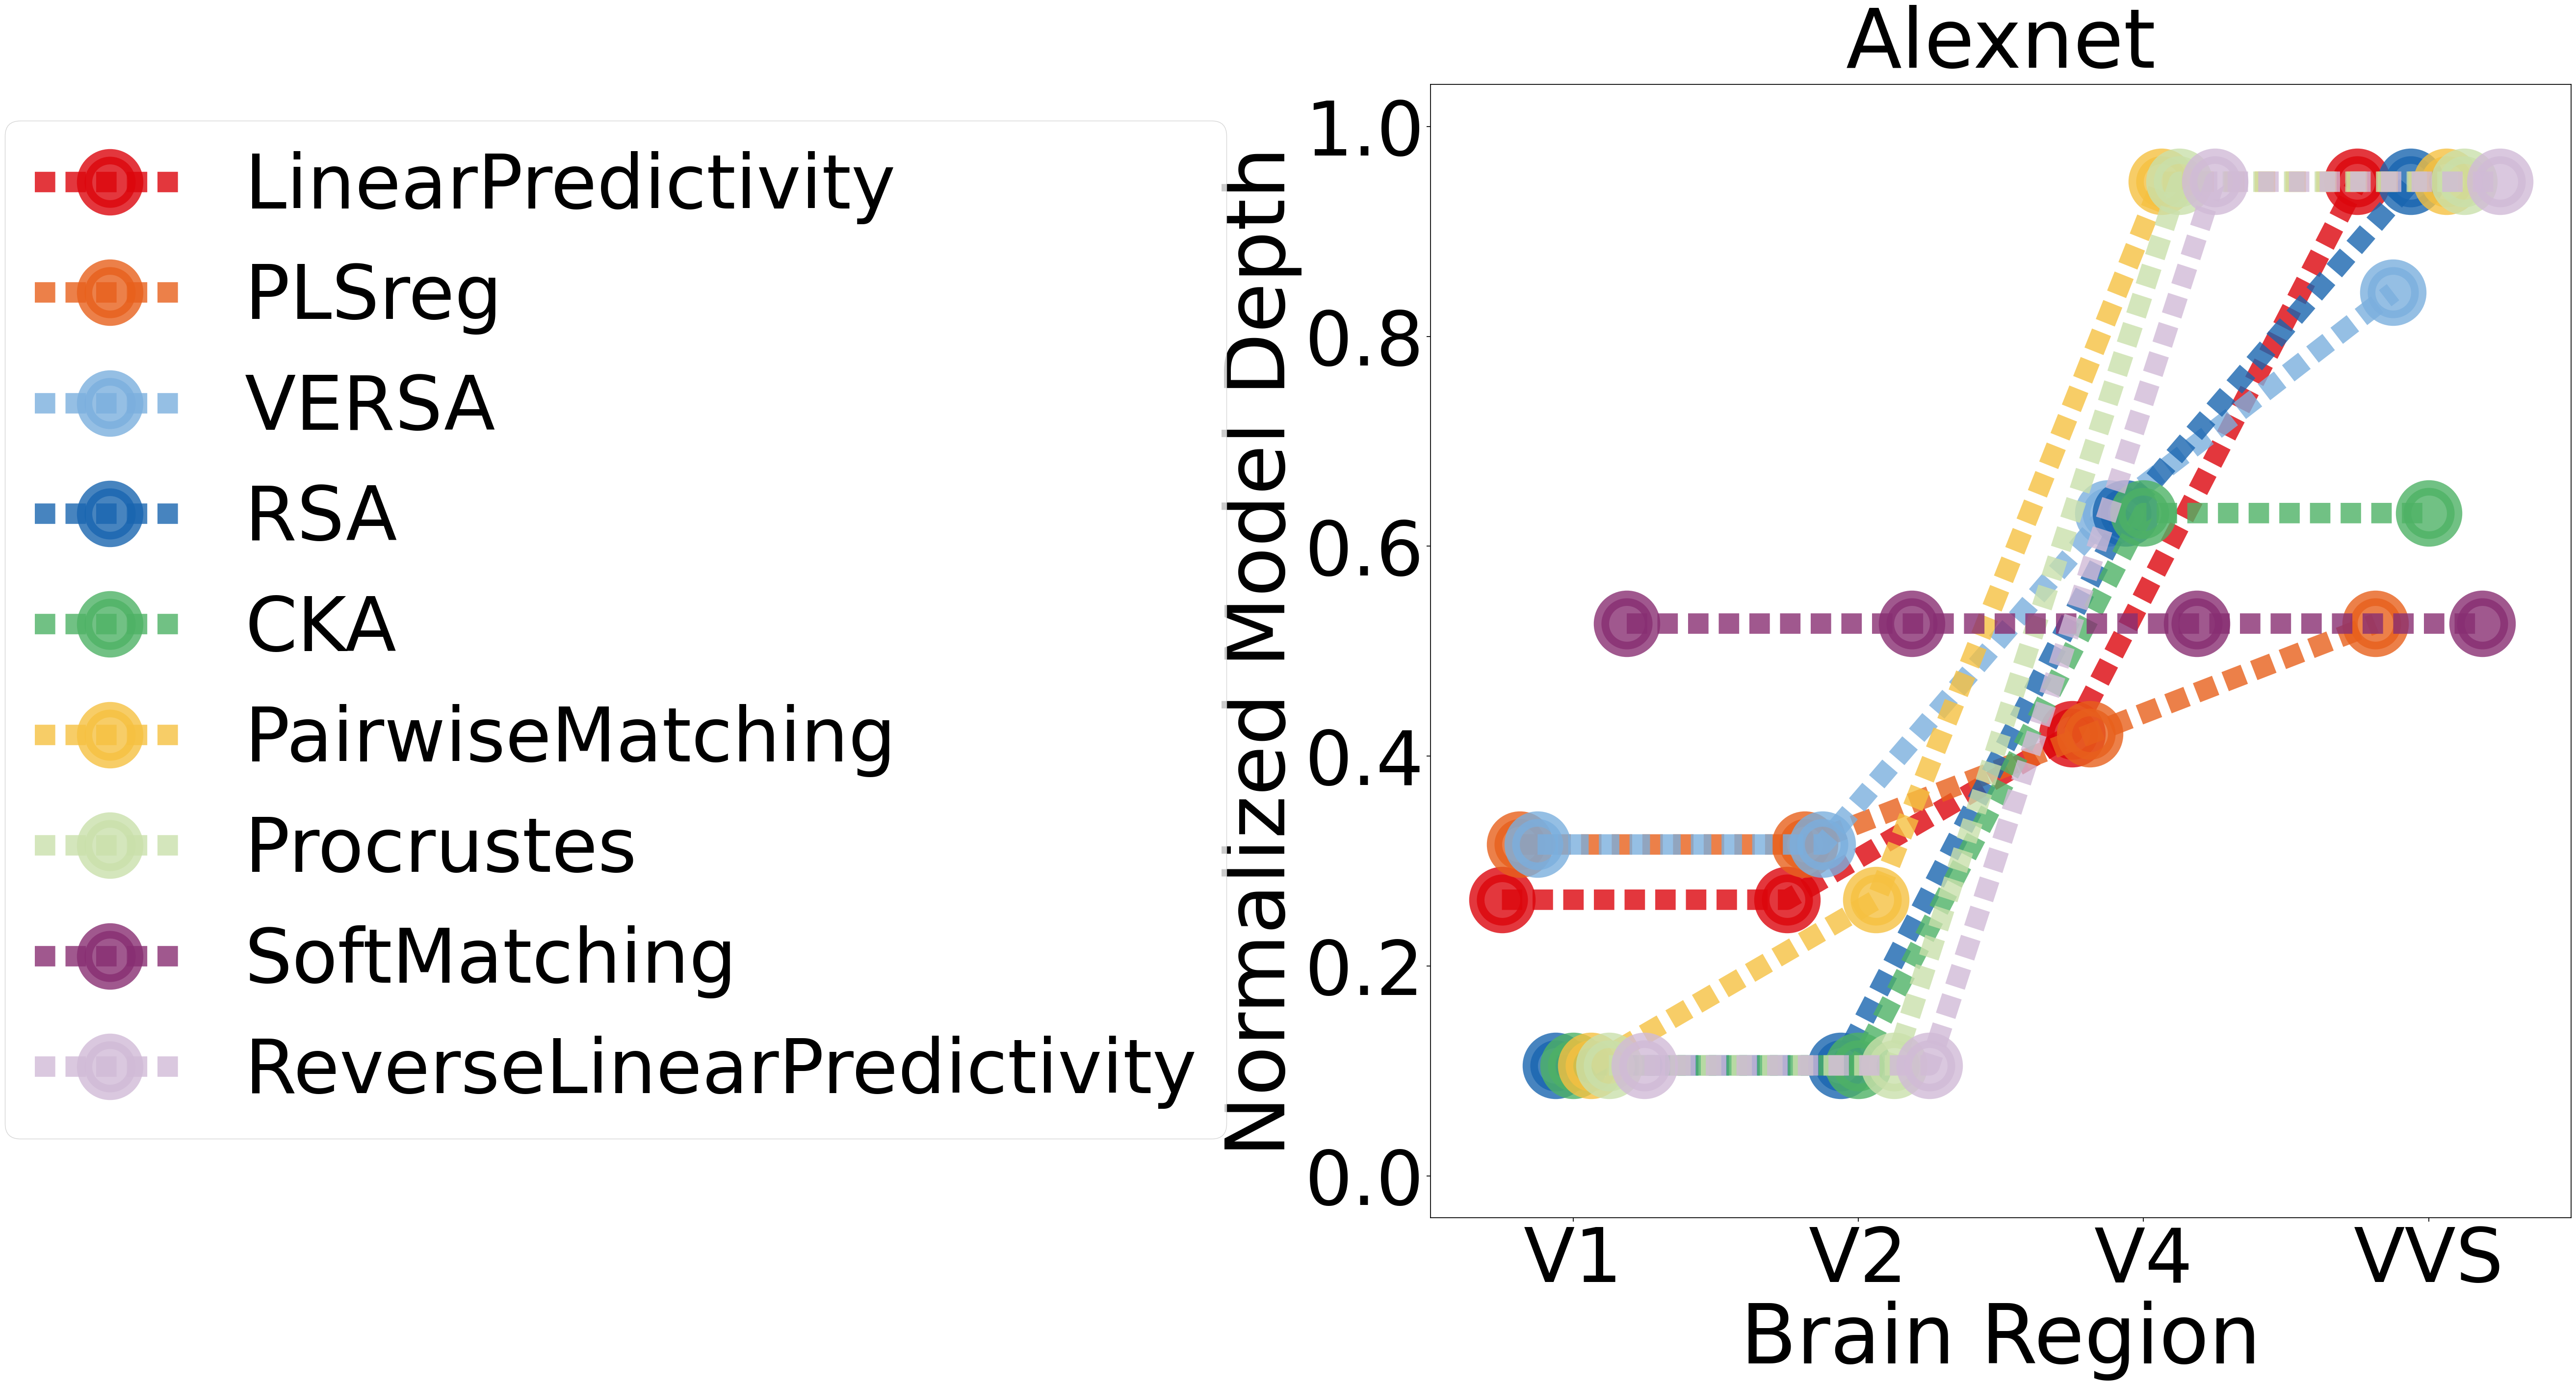

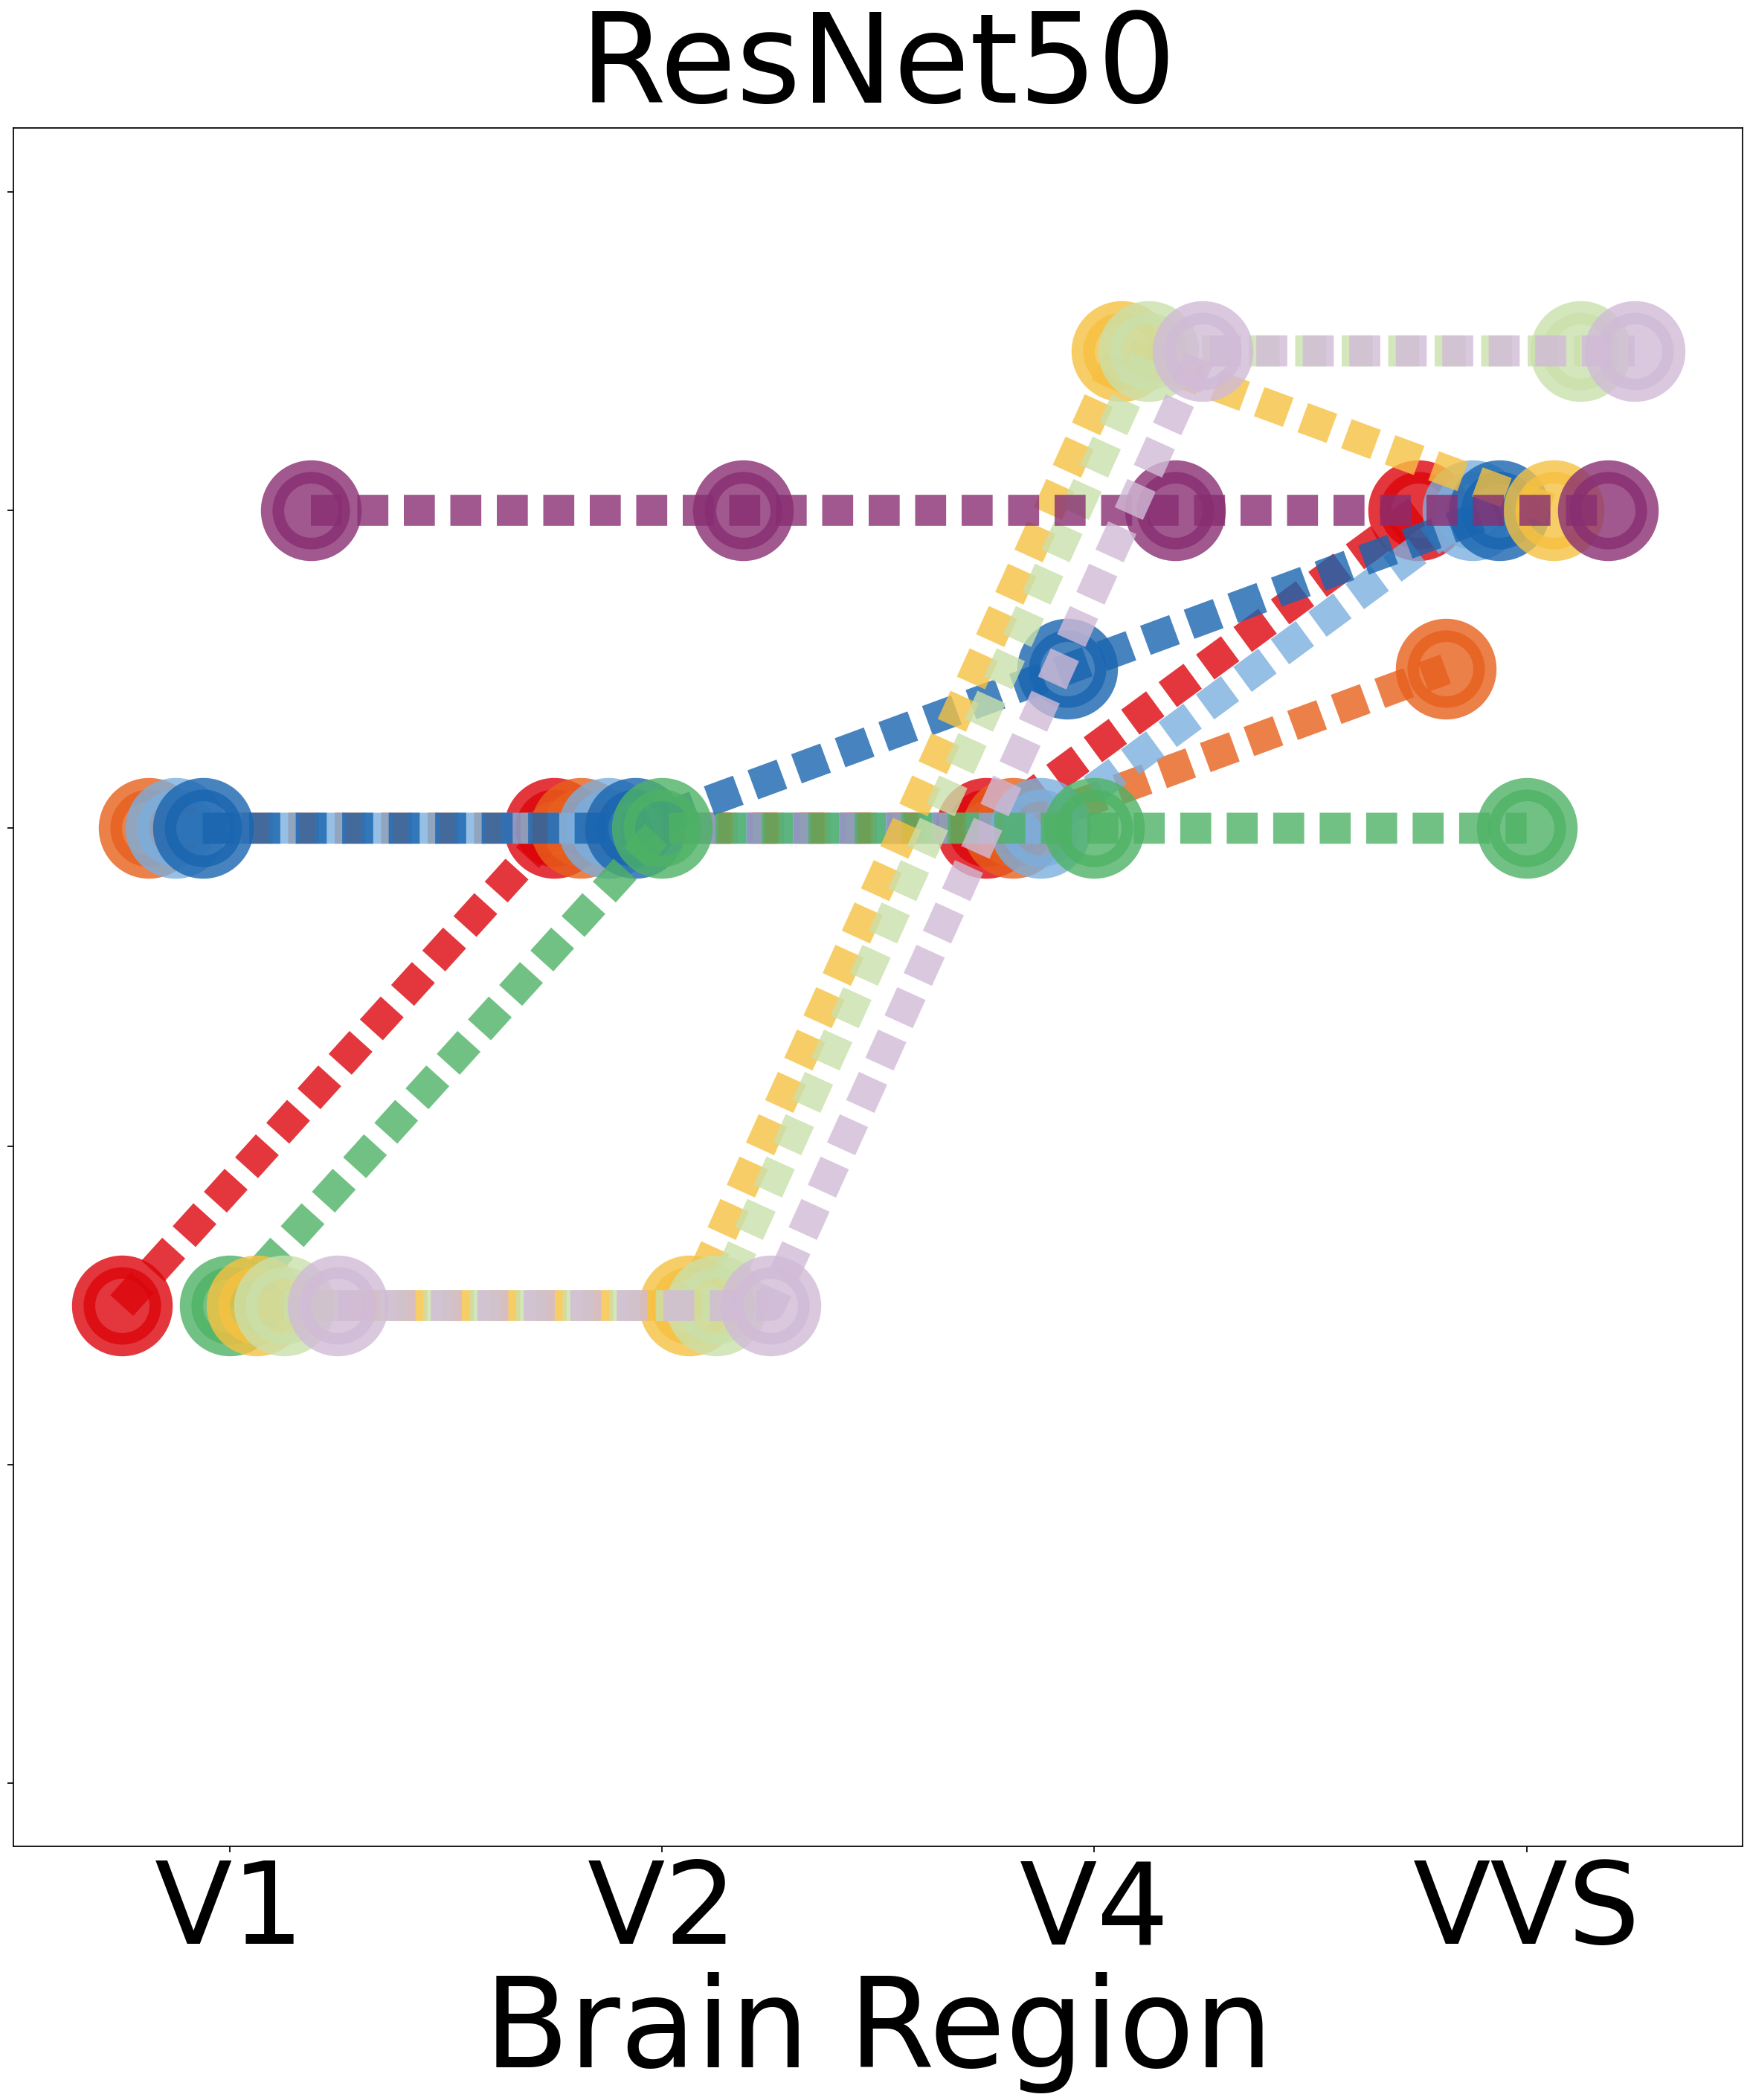

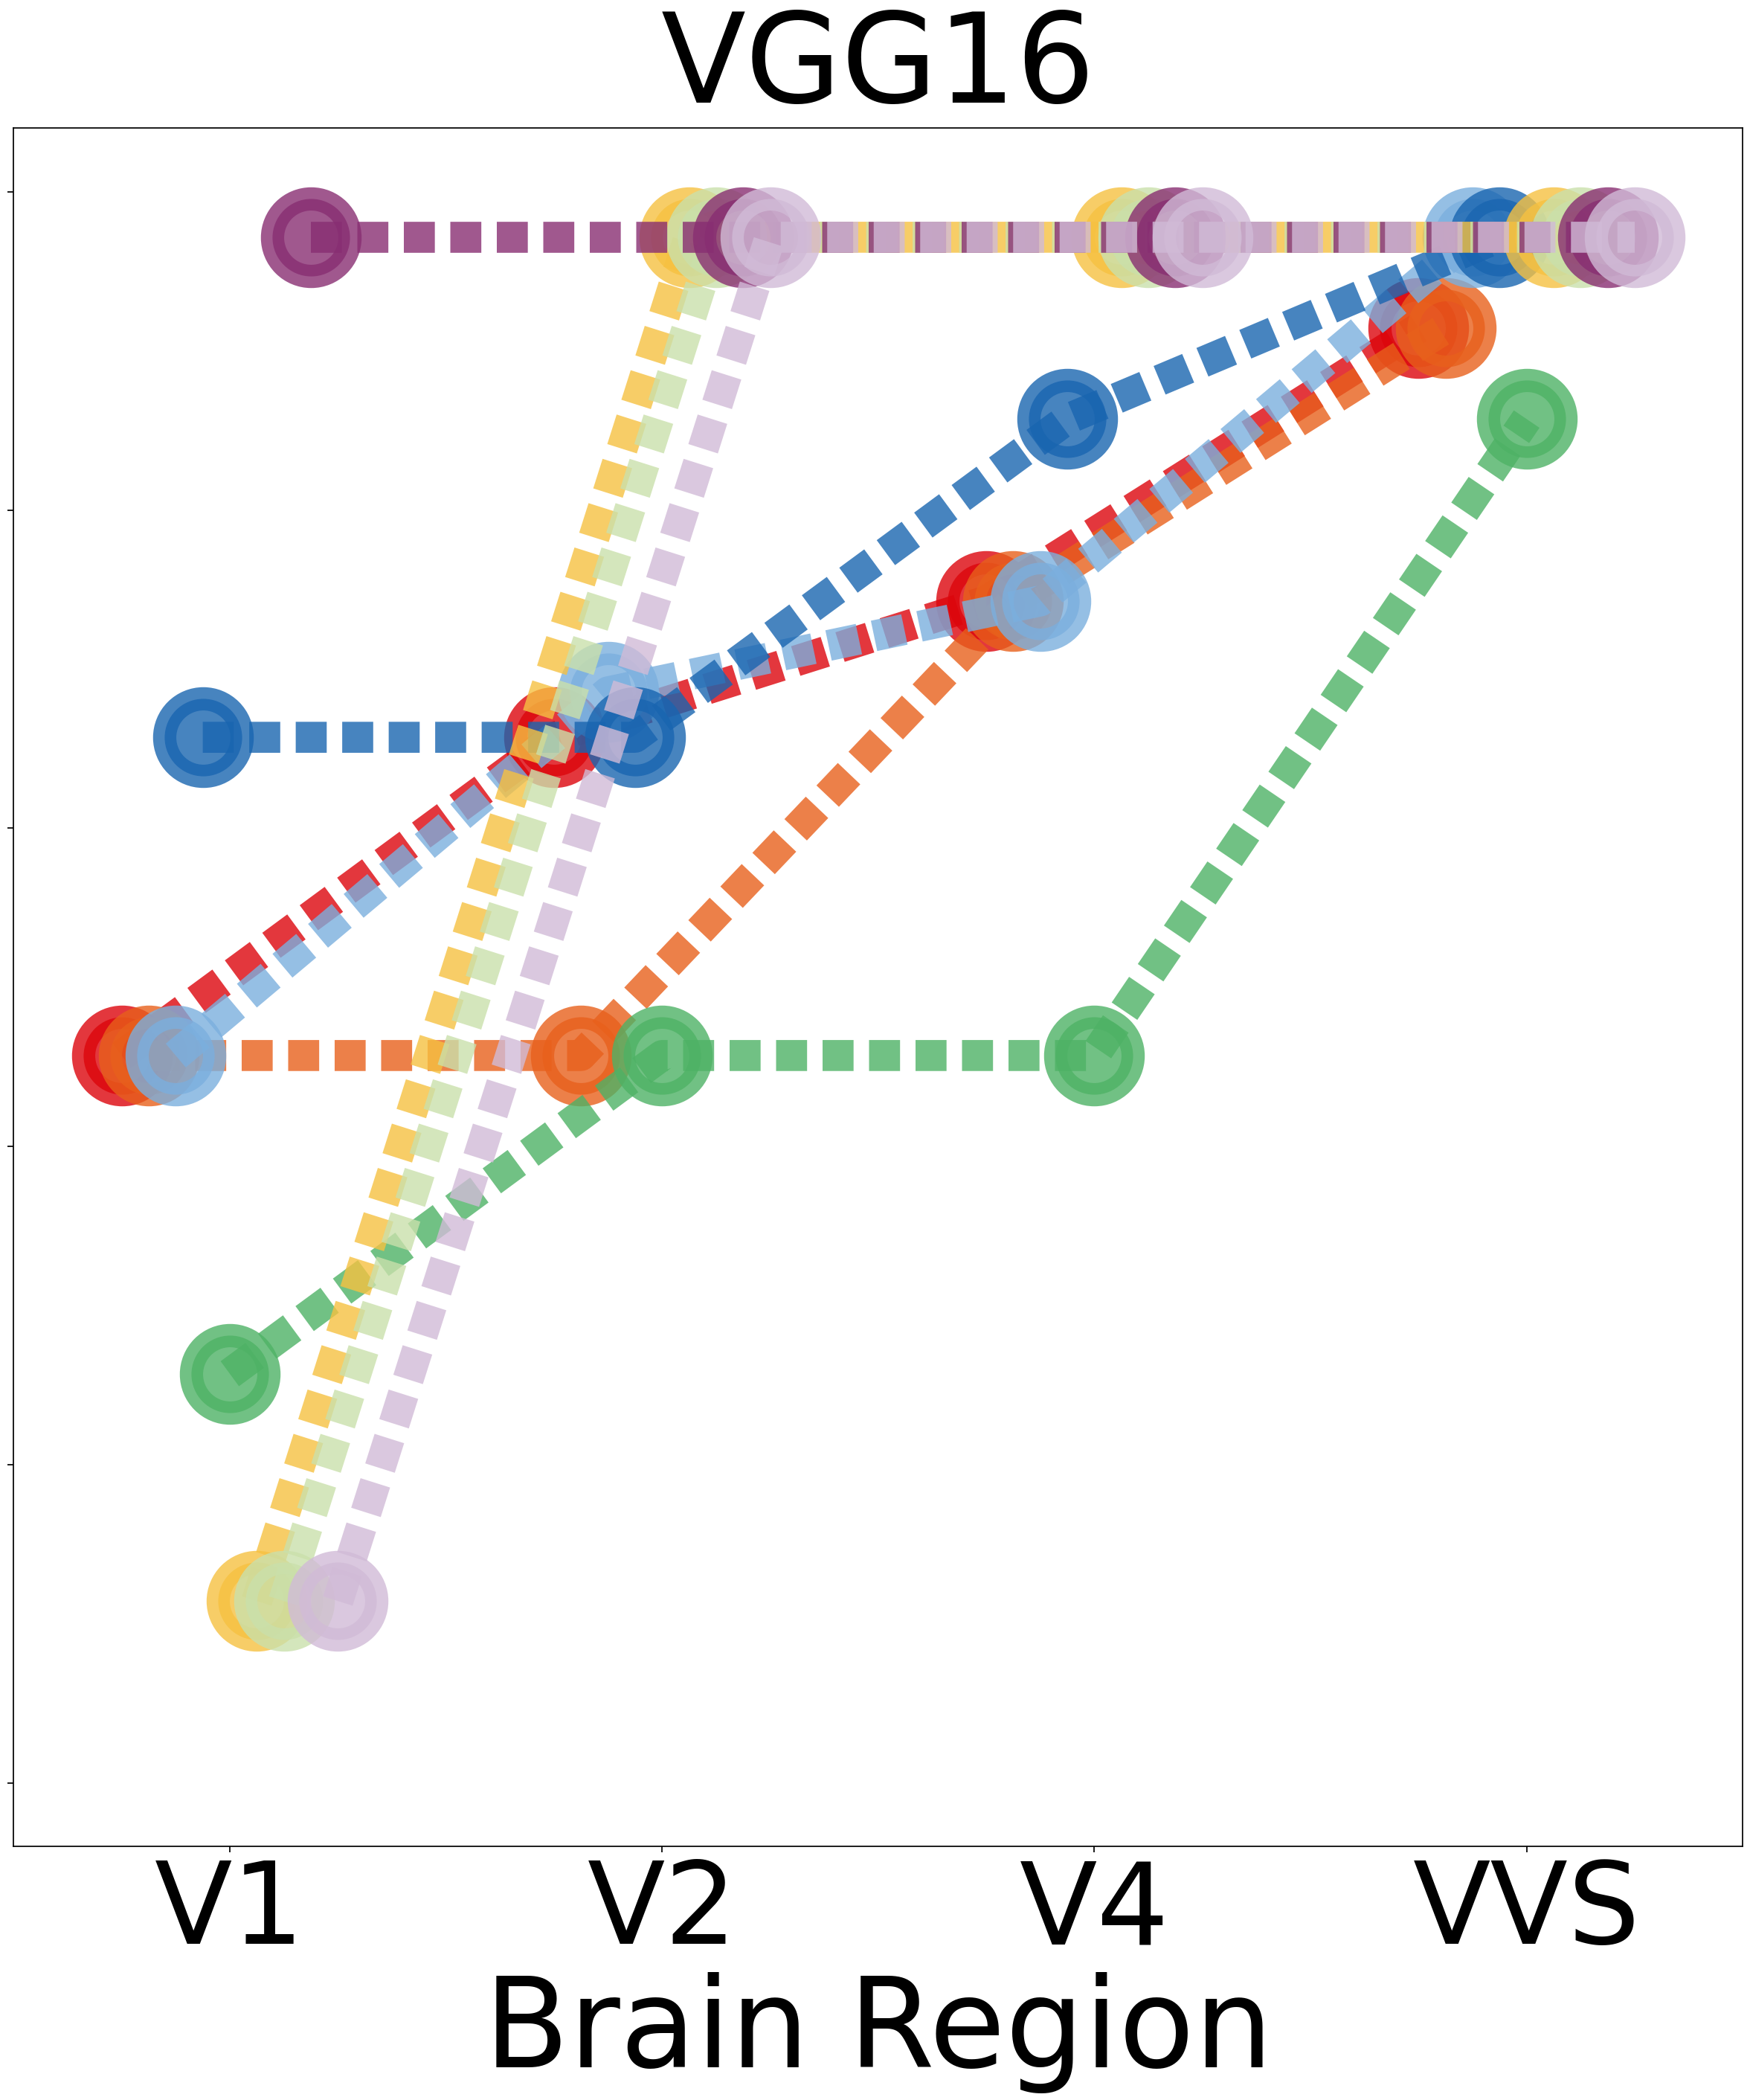

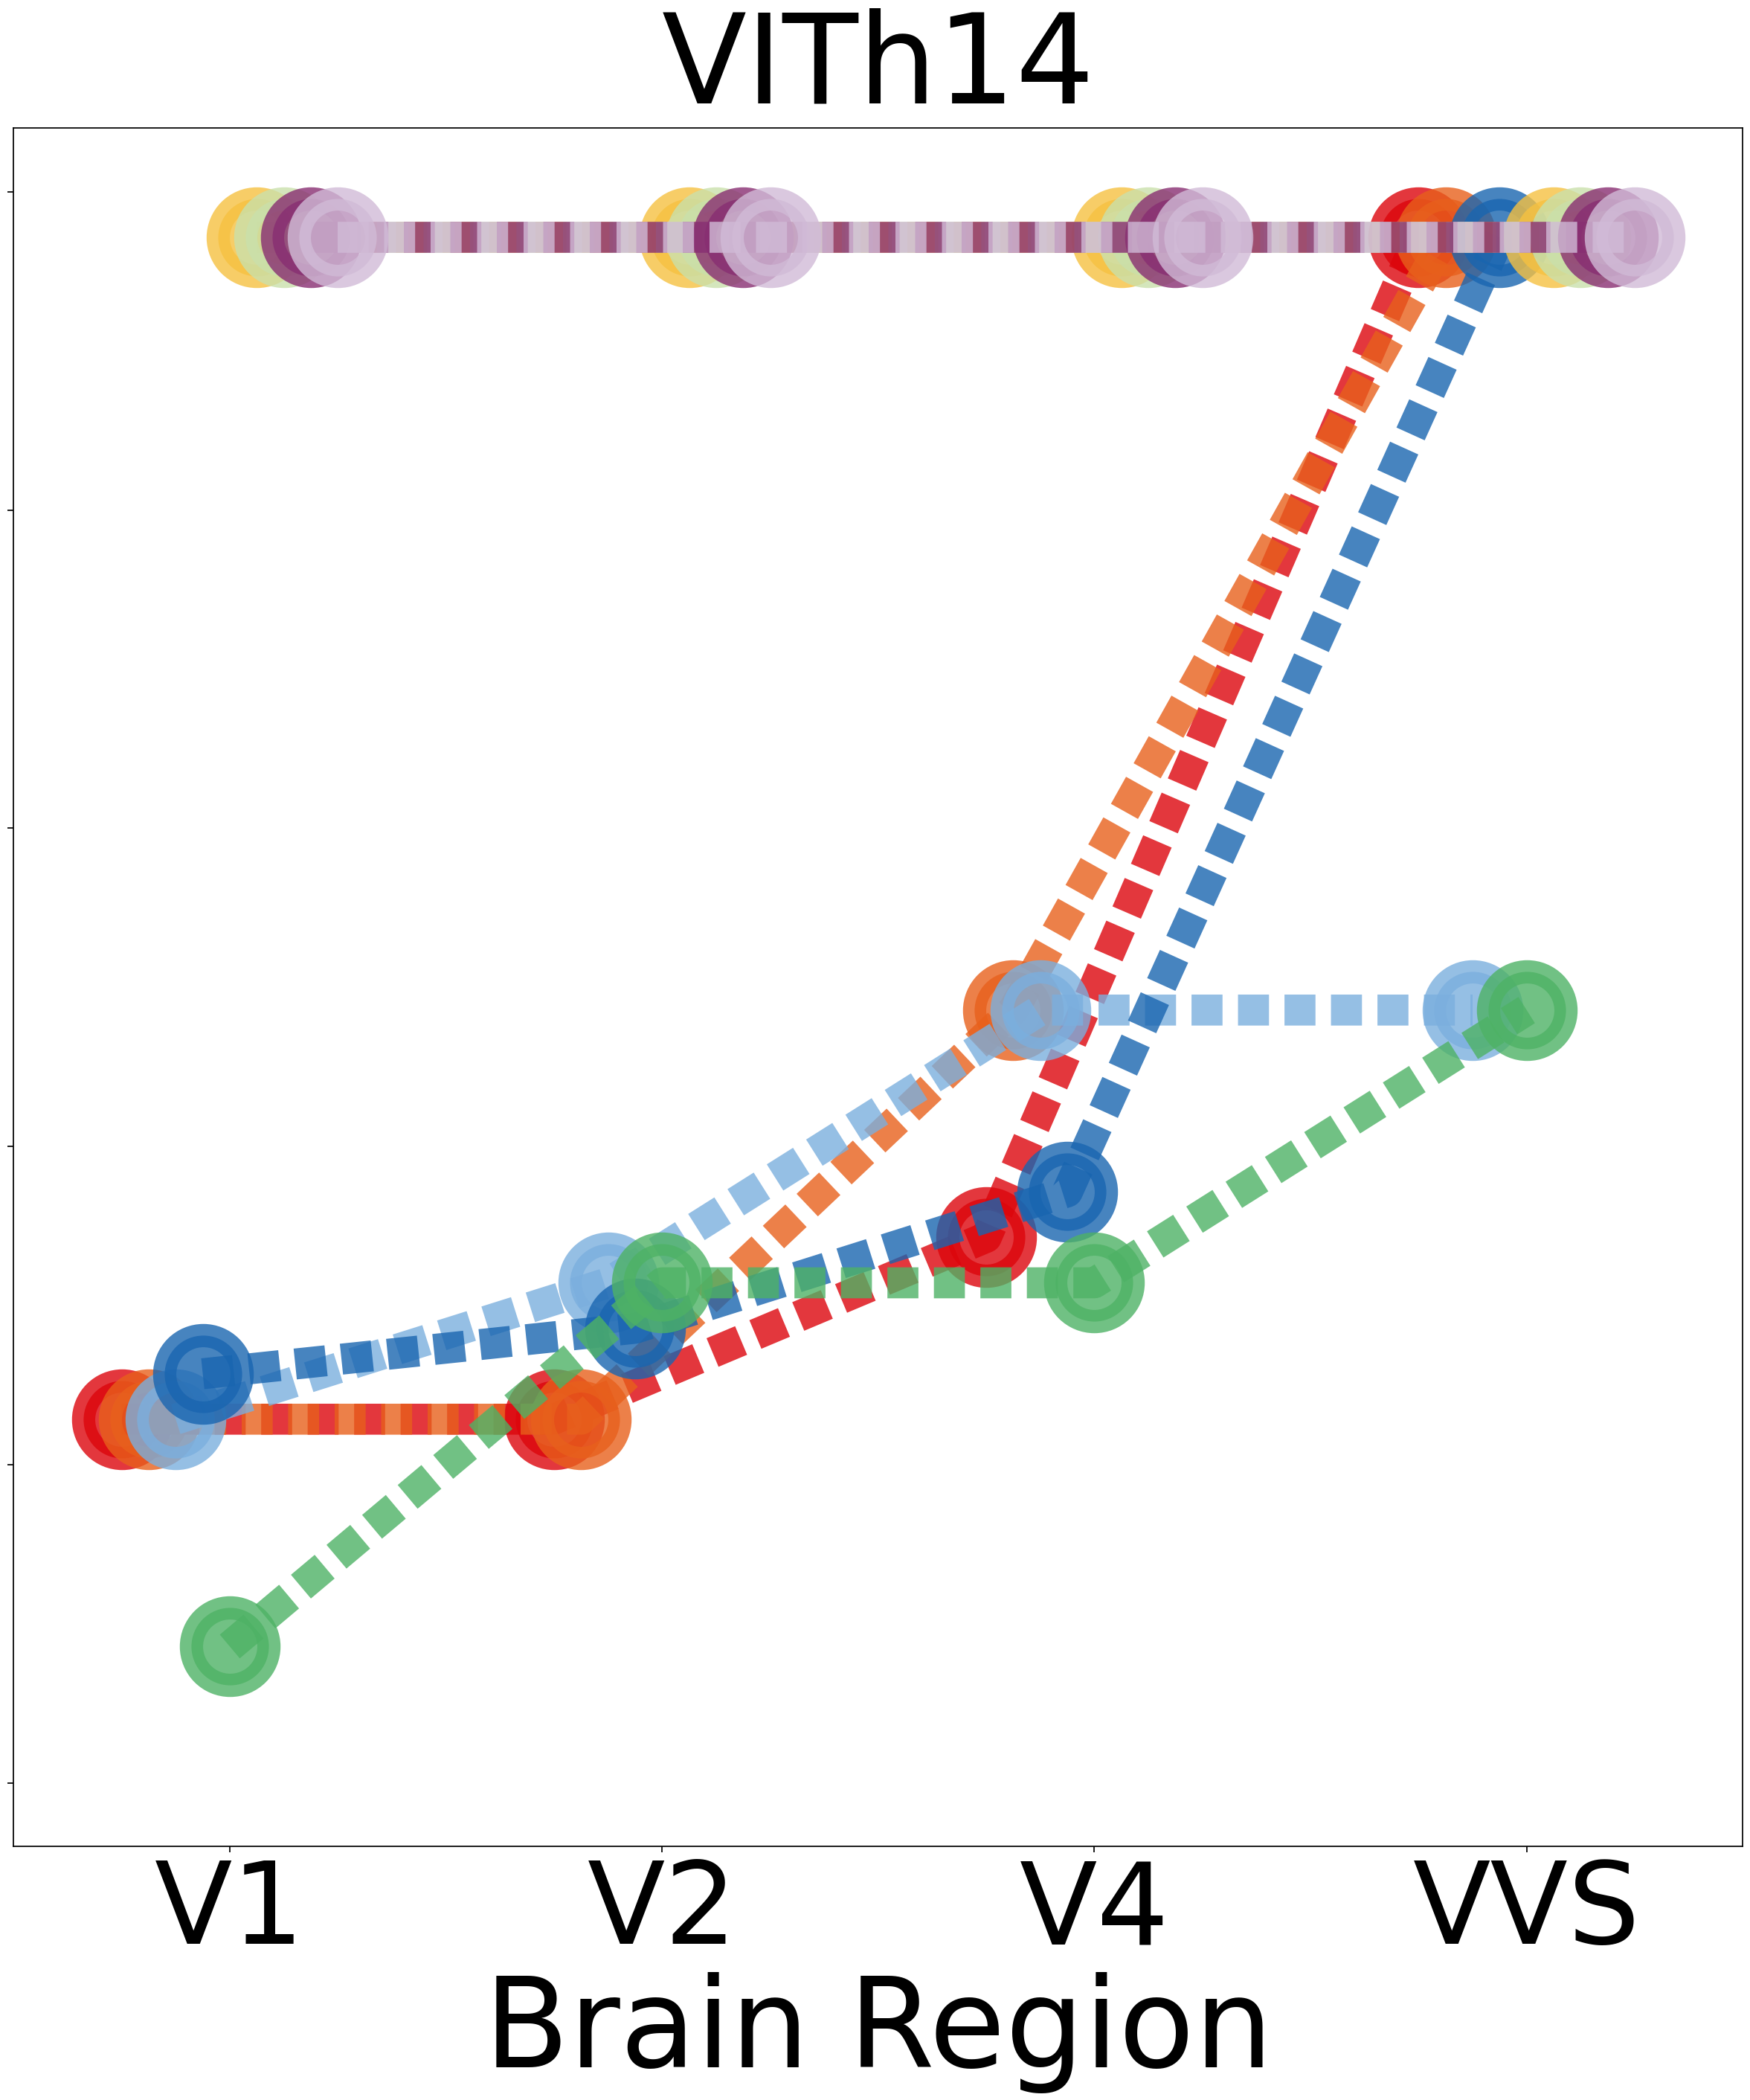

In [49]:
name=['Alexnet','ResNet50','VGG16','VITh14']
for i in name:
    figscale=30
    with sns.plotting_context("notebook",font_scale=figscale/3):

        fig, ax = plt.subplots(figsize=(figscale, figscale))
        sns.pointplot(
            data=alldfssaved[i],
            x="BrainArea",
            y="Layer",
            hue="Metric",
            marker=".",
            ls=(0,(1,.5)),
            markersize=figscale*MARKERSIZE,
            palette=METRICCOLORS,
            lw=figscale,
            ax=ax,
            dodge=.5,
            alpha=.8
        )

        ax.set_title(i)
        ax.set_xlabel("Brain Region")
        ax.set_ylabel("Normalized Model Depth")
        ax.set_ylim([-.04, 1.04])
        if i=='Alexnet':
            ax.legend(loc=(-1.25,.07))
        else:
            ax.legend().remove()
            ax.set_ylabel('')
            ax.set(yticklabels=[])  

        plt.show()

# Figure 3: Alexnet Comparison

In [50]:
nonNSD=True
scores={}
path='results/alexnet/'

for file_name in os.listdir(path):
    scores[file_name[:-4]]=np.load(path+file_name,allow_pickle=True)[()]
    for l in METRICS:
        scores[file_name[:-4]][l]=scores[file_name[:-4]][l].groupby('Layer', sort=False).mean()
        scores[file_name[:-4]][l]=np.array(list(scores[file_name[:-4]][l]['Score']))

In [51]:

        
rdm=[]
name=[]
for idataset in DATASETS:
    for iscale in DOWNSCALE:
        if idataset.startswith('NSD'):
            for ishared in NSDSHARED:
                for l in METRICS:
                    s=scores['{}_{}_{}'.format(idataset,ishared,iscale)][l]
                    if l=='Procrustes' or l=='SoftMatching':
                        s=-1*s
                    rdm.append(s)
                    name.append('{}_{}_{}'.format(idataset,ishared,iscale))

        elif nonNSD:

            for l in METRICS:
                s=scores['{}_{}'.format(idataset,iscale)][l]
                if l=='Procrustes' or l=='SoftMatching':
                    s=-1*s
                rdm.append(s)
                name.append('{}_{}'.format(idataset,iscale))
                



(32, 9, 9)


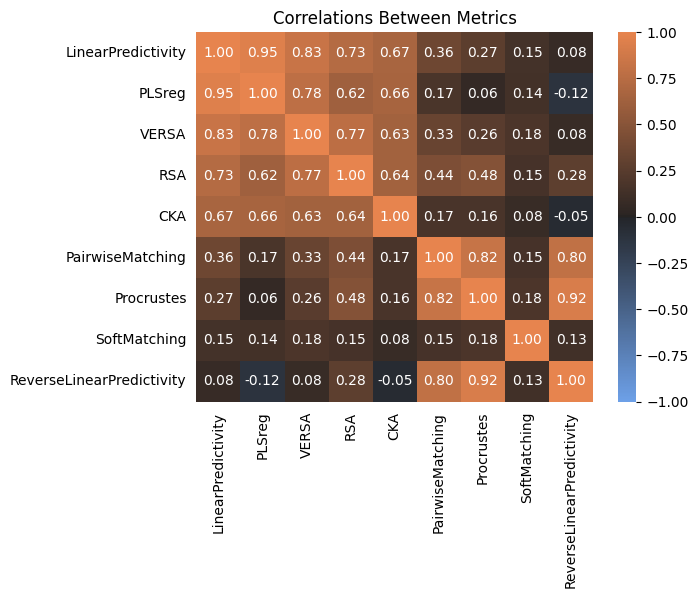

In [52]:
all_rdms=[]
dataset_name=[]
for idataset in DATASETS:

    for iscale in DOWNSCALE:
        if idataset.startswith('NSD'):
            for ishared in NSDSHARED:
                rdm=[]
                for l in METRICS:
                    s=scores['{}_{}_{}'.format(idataset,ishared,iscale)][l]
                    if l=='Procrustes'  or l=='SoftMatching':
                        s=-1*s
                    rdm.append(s)
                dataset_name.append('{}_{}'.format(idataset,ishared))
                all_rdms.append(rdmmaker(rdm))
                

        elif nonNSD:
            rdm=[]
            for l in METRICS:
                s=scores['{}_{}'.format(idataset,iscale)][l]
                if l=='Procrustes'  or l=='SoftMatching':
                    s=-1*s
                rdm.append(s)
            dataset_name.append(idataset)
            all_rdms.append(rdmmaker(rdm))
all_rdms=np.array(all_rdms)
print(all_rdms.shape)
ax =sns.heatmap(np.mean(all_rdms,axis=0), annot=True, fmt=".2f",vmin=-1,vmax=1, yticklabels=METRICS, xticklabels=METRICS,cmap=cmapsns)
ax.tick_params(left=False, bottom=False)
plt.title('Correlations Between Metrics')
plt.show()

In [53]:
taus=pd.DataFrame(columns=['Tau','Comparison','NSD'])
comp=[]
for i in range(all_rdms.shape[0]):
    for k in range(all_rdms.shape[0]):
        if i!=k:
            temp=all_rdms[i]
            temp2=all_rdms[k]
            b=kendalltau(temp[np.triu_indices(temp.shape[0], k=1)] ,temp2[np.triu_indices(temp2.shape[0], k=1)])[0]
            if dataset_name[i]==dataset_name[k]:
                a='Reduction'

            else:
                a='Dataset'
            if 'NSD' in dataset_name[i] and 'NSD' in dataset_name[k]:
                c='Within Dataset'
            elif 'Inanimate' in dataset_name[i] and 'Inanimate' in dataset_name[k]:
                c='Within Dataset'

            elif 'Orientation' in dataset_name[i] and 'Orientation' in dataset_name[k]:
                c='Within Dataset'

            elif 'Monkey_V1' in dataset_name[i] and 'Monkey_V1' in dataset_name[k]:
                c='Within Dataset'

            elif 'Monkey_IT' in dataset_name[i] and 'Monkey_IT' in dataset_name[k]:
                c='Within Dataset'

            else:
                c='Across Datasets'
            taus.loc[len(taus)]={'Tau':b,'Comparison':a,'NSD':c}

print(np.mean(taus['Tau'])) 

0.4193676395289299


In [54]:
print(np.mean(taus.loc[(taus['Comparison']=='Dataset')]['Tau'])) 
print(np.mean(taus.loc[(taus['Comparison']=='Reduction')]['Tau'])) 

0.41739417989418
0.4785714285714286


In [55]:
print(np.mean(taus.loc[(taus['Comparison'] == 'Dataset') & (taus['NSD'] == 'Within Dataset')]['Tau'])) 
print(np.mean(taus.loc[(taus['Comparison'] == 'Dataset') & (taus['NSD'] == 'Across Datasets')]['Tau'])) 
from scipy.stats import ttest_ind

print(ttest_ind(taus.loc[(taus['Comparison'] == 'Dataset') & (taus['NSD'] == 'Within Dataset')]['Tau'],taus.loc[(taus['Comparison'] == 'Dataset') & (taus['NSD'] == 'Across Datasets')]['Tau'])) 

0.5068627450980392
0.38202288667404954
Ttest_indResult(statistic=9.951670111789397, pvalue=2.858565240601969e-22)


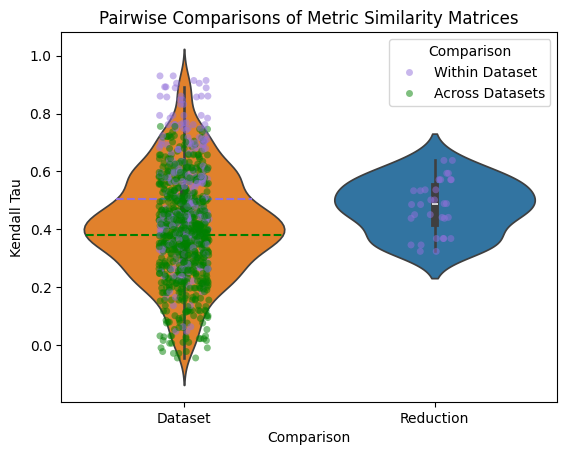

In [56]:
# Calculate means for NSD and non-NSD groups
mean_nsd = taus[taus['NSD'] == 'Within Dataset']['Tau'].mean()
mean_non_nsd = taus[taus['NSD'] == 'Across Datasets']['Tau'].mean()

# Create the base boxplot
box_plot = sns.violinplot(x='Comparison', y='Tau', data=taus, hue='Comparison',palette=['C1','C0'])

# Create the scatter plot with different colors
sns.stripplot(x='Comparison', y='Tau', data=taus, hue='NSD', palette=['mediumpurple','green'], dodge=False, jitter=True, alpha=0.5)


plt.hlines(mean_nsd, -.27, .27, colors='mediumpurple', linestyles='--')
plt.hlines(mean_non_nsd, -.39, .4, colors='green', linestyles='--')

# Customize the plot
plt.title('Pairwise Comparisons of Metric Similarity Matrices')
plt.ylabel('Kendall Tau')
plt.legend(title='Comparison')
plt.show()

# Figure 4: Across Model Ranking

In [57]:
directory_path = 'results/'
out=list_files_recursive(directory_path,NSD=True)
Scores_Across_Models=pd.DataFrame(columns=['Brain Region','Model','Metric','Score'])
for i in out:
    
    for j in METRICS:
        model_name=i.split('/')[-2]
        brainarea=i.split('/')[-1].split('_')[1]
        data=np.load(i,allow_pickle=True)[()]
        data=data[j].groupby('Layer', sort=False).mean()
        if j=='Procrustes' or j=='SoftMatching':
            scale=-1
        else:
            scale=1
        
        Scores_Across_Models.loc[len(Scores_Across_Models)]={'Brain Region':brainarea,'Model':model_name,'Metric':j,'Score':np.max(scale*data['Score'])} 
        
            
Rank_Across_Models=pd.DataFrame(columns=['Brain Region','Model','Metric','Rank'])

for i in NSDAREAS:
    for j in METRICS:
        tempdf=Scores_Across_Models.loc[(Scores_Across_Models['Brain Region'] == i) & (Scores_Across_Models['Metric'] == j)]
        models=list(tempdf['Model'])
        scores=list(tempdf['Score'])
        ranks=rank_values(scores)
        for f in range(len(ranks)):
            Rank_Across_Models.loc[len(Rank_Across_Models)]={'Brain Region':i,'Model':models[f],'Metric':j,'Rank':ranks[f]} 
        



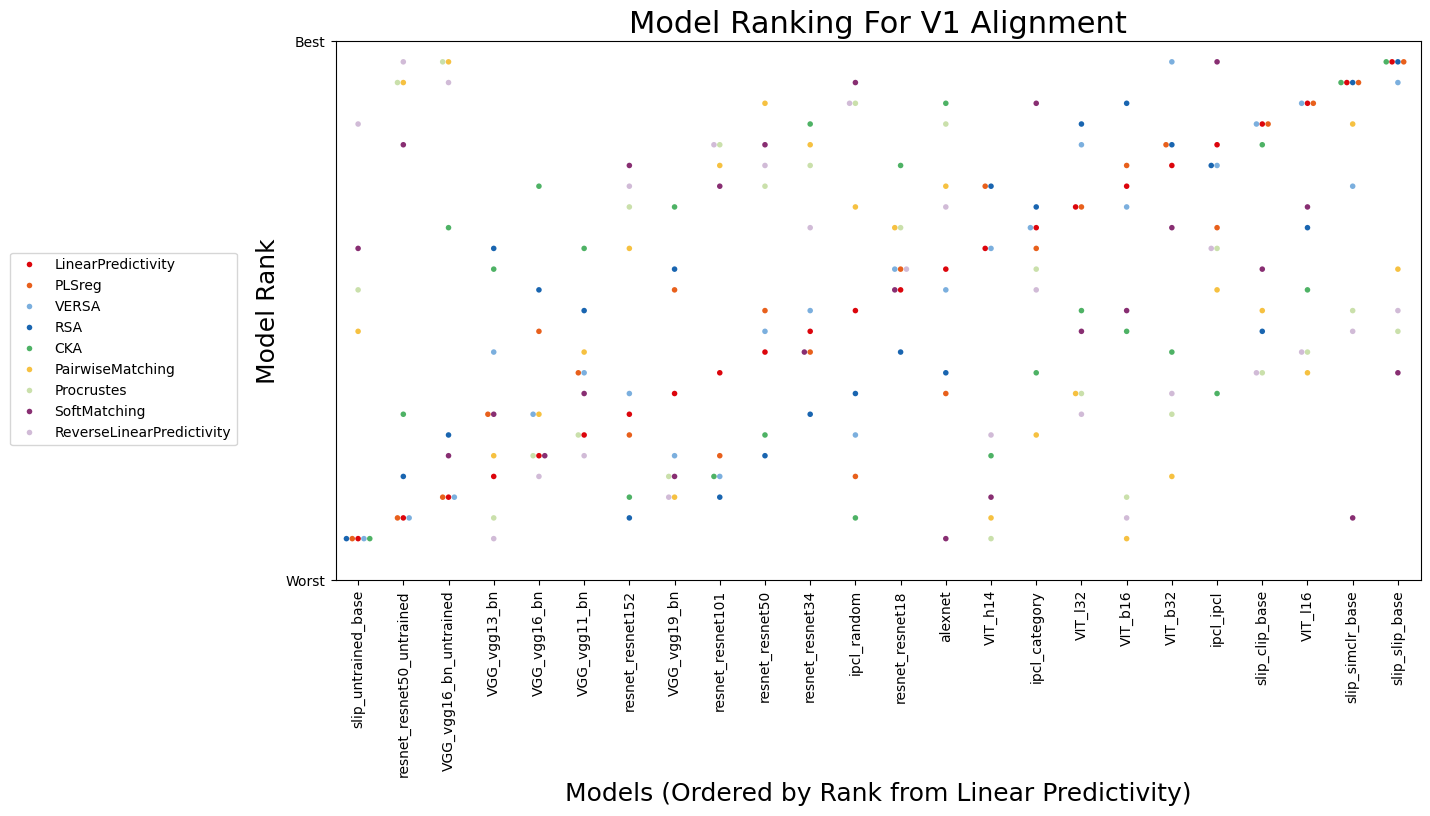

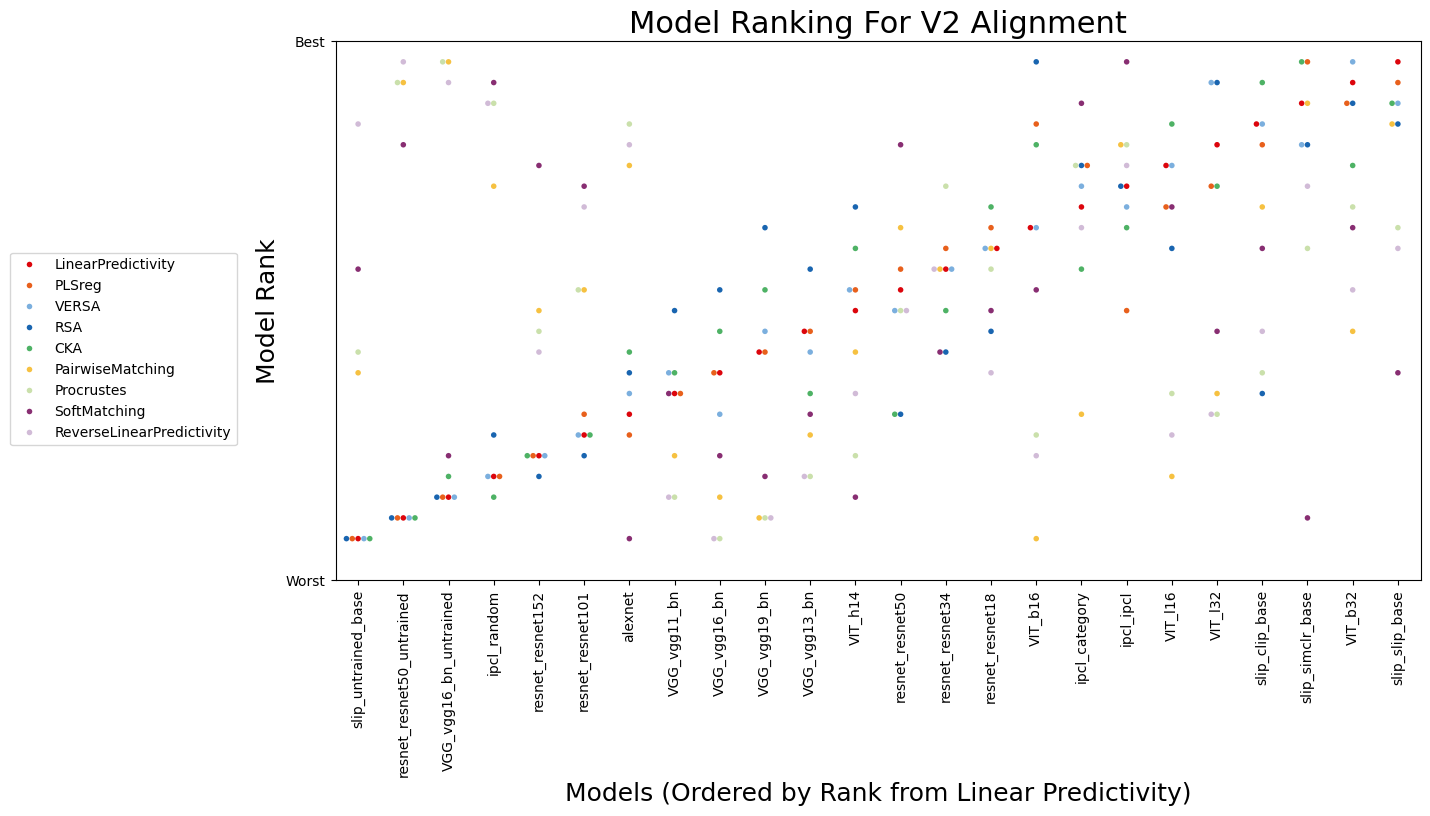

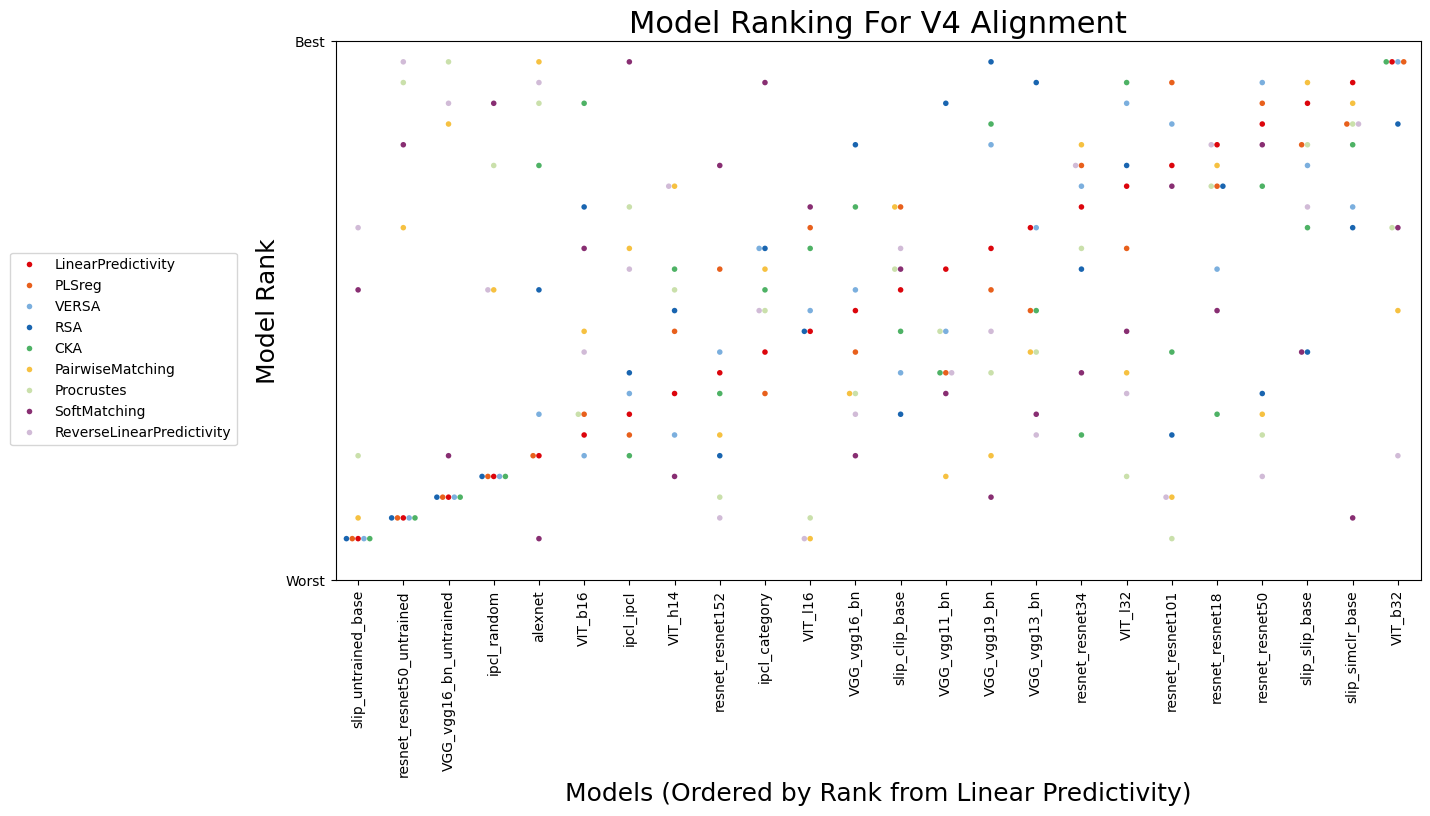

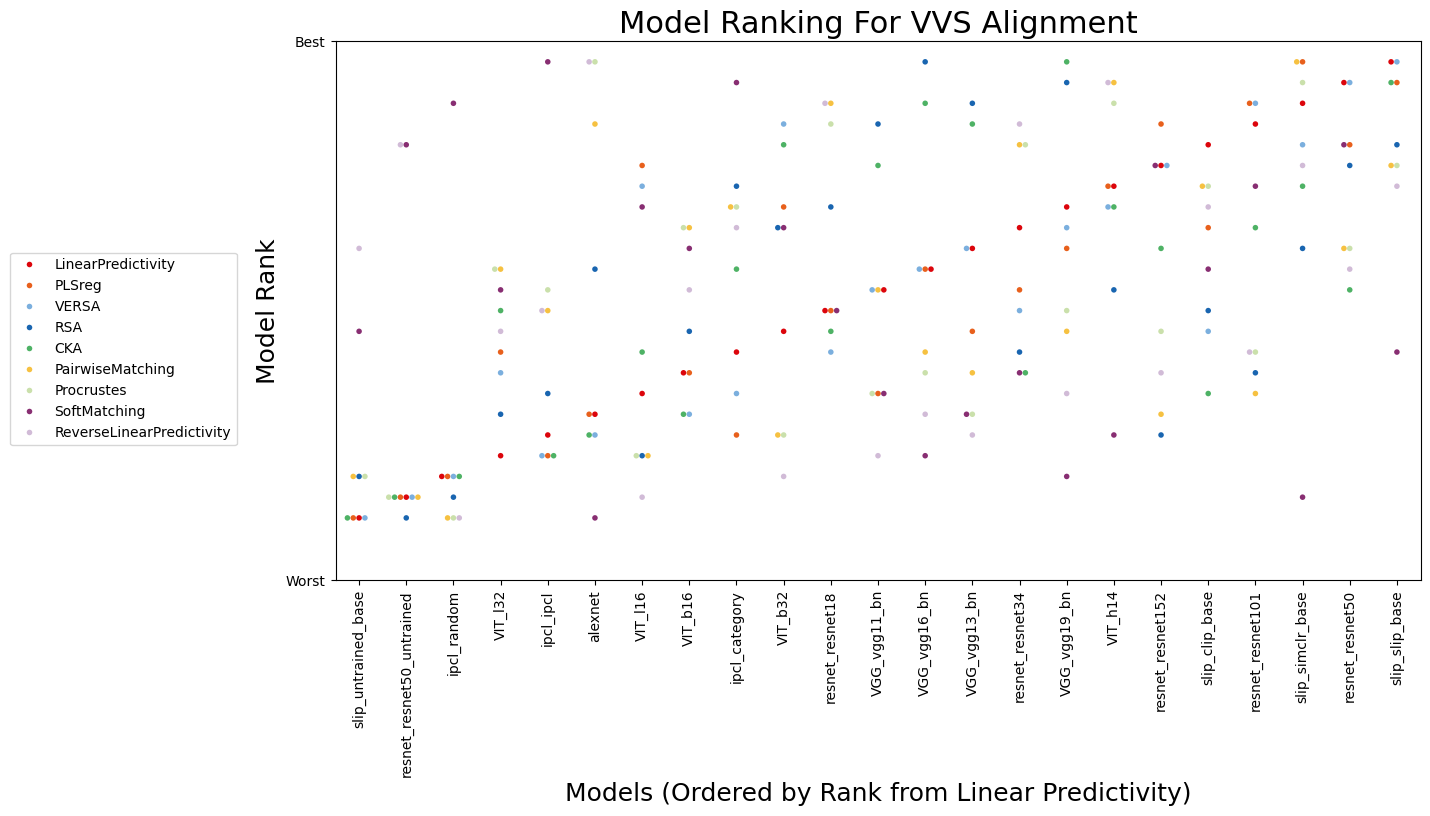

In [58]:
metric_to_sort = 'LinearPredictivity'

for i in NSDAREAS:
    tempdf=Rank_Across_Models.loc[(Rank_Across_Models['Brain Region']==i)]
    metricdf = tempdf[tempdf['Metric'] == metric_to_sort]
    tempdf= tempdf[tempdf['Metric'] != metric_to_sort]
    # Sort the filtered DataFrame by the 'Rank' column
    metricdf = metricdf.sort_values(by='Rank',ascending=False)

    # Merge the sorted filtered DataFrame with the original DataFrame to keep all data points
    tempdf = pd.concat([metricdf, tempdf])

    plt.figure(figsize=(14, 7))
    sns.swarmplot(data=tempdf, x='Model', y='Rank', hue='Metric', palette=METRICCOLORS,s=4)
    plt.xticks(rotation=90)
    plt.title(f'Model Ranking For {i} Alignment', fontsize=22)
    plt.legend(loc=(-.3,.25))
    #plt.tight_layout()
    plt.yticks([0,26],['Best','Worst'])
    plt.ylim(26, 0)
    plt.ylabel("Model Rank", fontsize=18)
    plt.xlabel("Models (Ordered by Rank from Linear Predictivity)", fontsize=18)

    plt.show()

0.10142482652516162


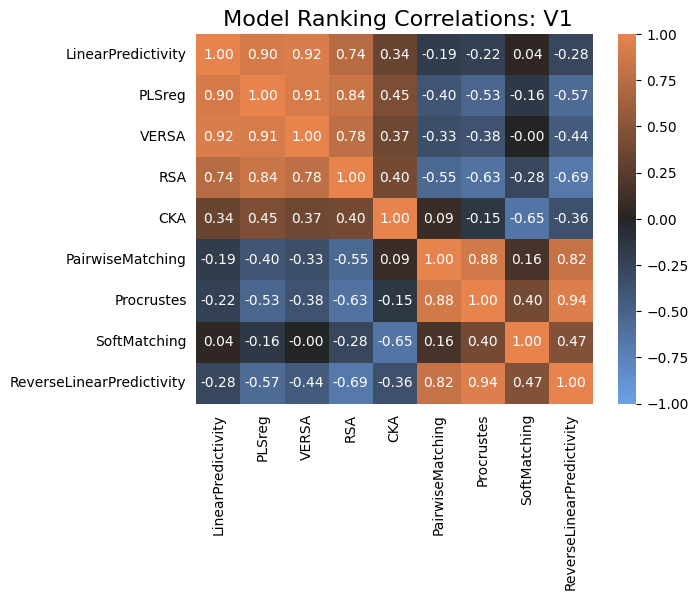

0.2337228648384818


In [ ]:
allrdms=[]
for j in NSDAREAS:
    tempv=Rank_Across_Models.loc[(Rank_Across_Models['Brain Region']==j)]
    rdm=[]
    for i in METRICS:
        temp=tempv.loc[(tempv['Metric']==i)]
        temp=temp.sort_values('Model')
        rdm.append(list(temp['Rank']))
    temprdm=rdmmakerspear(rdm)
    allrdms.append(temprdm)
    print(np.mean(temprdm[np.triu_indices(temprdm.shape[0], k=1)]))
    ax =sns.heatmap(temprdm, annot=True, fmt=".2f",vmin=-1,vmax=1, yticklabels=METRICS, xticklabels=METRICS,cmap=cmapsns)
    ax.tick_params(left=False, bottom=False)
    plt.title(' Model Ranking Correlations: {}'.format(j), fontsize=16)
    plt.show()

# Figure 5: How much do we know

In [26]:
minandmax={}
catpreds={}
for i in os.listdir('results/minandmax/'):
    if '1000' in i:
        minandmax[i.split('_')[1]]=np.load('results/minandmax/'+i,allow_pickle=True)[()]
for i in os.listdir('results/catpreds/'):
    if '1000' in i:
        catpreds[i.split('_')[1]]=np.load('results/catpreds/'+i,allow_pickle=True)[()]
        

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


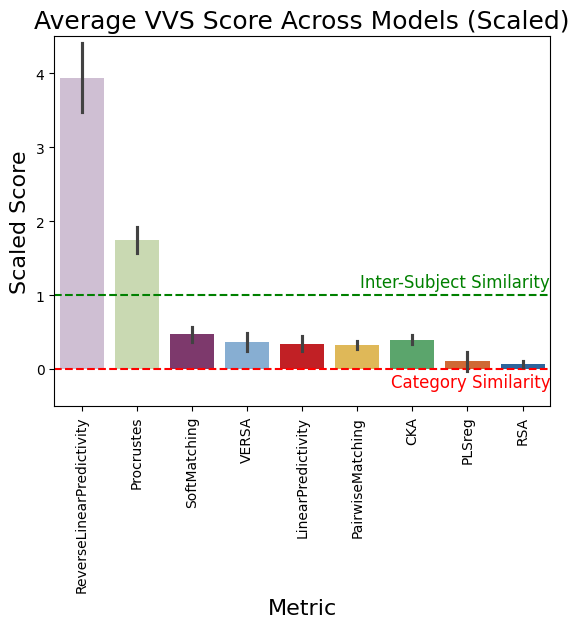

In [27]:
knowdict=pd.DataFrame(columns = ['Metric','Score'])

for i in METRICS:
    temp=Scores_Across_Models.loc[(Scores_Across_Models['Metric'] == i) & (Scores_Across_Models['Brain Region'] == 'VVS')]



    scale=1
    if i=='Procrustes' or i=='SoftMatching':
        scale=-1
    min2=scale*np.mean(catpreds['VVS'][i])
    max1=scale*np.mean(minandmax['VVS'][i][0])
    temp_mean=scaler(temp['Score'],min2,max1)
    for j in temp_mean:
        knowdict.loc[len(knowdict)] = {"Metric":i,'Score':j}    
knowdict=knowdict.sort_values('Score',ascending=False)  
plt.text(x=8.5, y=1.05, s='Inter-Subject Similarity', ha='right', va='bottom', fontsize=12 ,c='green')
plt.text(x=8.5, y=-.05, s='Category Similarity', ha='right', va='top', fontsize=12,c='red')
plt.ylim([-.5,4.5])
plt.axhline(0,linestyle='dashed',c='red')
plt.axhline(1,linestyle='dashed',c='green')
sns.barplot(knowdict,x='Metric',y='Score',palette=METRICCOLORS, errorbar='se')



plt.legend(loc=LEGENDLOC).remove()
plt.xticks(rotation=90)
plt.title('Average VVS Score Across Models (Scaled)', fontsize=18)
plt.xlabel('Metric', fontsize=16)
plt.ylabel('Scaled Score', fontsize=16)
plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


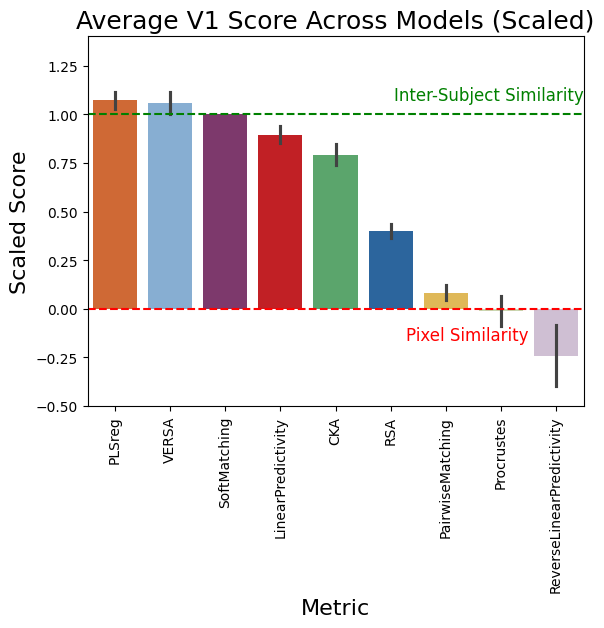

In [28]:

knowdict=pd.DataFrame(columns = ['Metric','Score'])

for i in METRICS:
    temp=Scores_Across_Models.loc[(Scores_Across_Models['Metric'] == i) & (Scores_Across_Models['Brain Region'] == 'V1')]

    scale=1
    if i=='Procrustes'  or i=='SoftMatching':
        scale=-1
    min1=scale*np.mean(minandmax['V1'][i][1])
    max1=scale*np.mean(minandmax['V1'][i][0])
    temp_mean=scaler(temp['Score'],min1,max1)
    for j in temp_mean:
        knowdict.loc[len(knowdict)] = {"Metric":i,'Score':j}    

knowdict_mean = (
    knowdict.groupby("Metric")["Score"]
    .mean()
    .reset_index()
    .sort_values("Score", ascending=False)
)

knowdict["Metric"] = pd.Categorical(
    knowdict["Metric"], categories=knowdict_mean["Metric"], ordered=True
)


sns.barplot(knowdict,x='Metric',y='Score',palette=METRICCOLORS, errorbar='se')
plt.legend(loc=LEGENDLOC).remove()
plt.xticks(rotation=90)
plt.title('Average V1 Score Across Models (Scaled)', fontsize=18)
plt.xlabel('Metric', fontsize=16)
plt.ylabel('Scaled Score', fontsize=16)
plt.text(x=8.5, y=1.05, s='Inter-Subject Similarity', ha='right', va='bottom', fontsize=12 ,c='green')
plt.text(x=7.5, y=-.09, s='Pixel Similarity', ha='right', va='top', fontsize=12,c='red')
plt.ylim([-.5,1.4])
plt.axhline(0,linestyle='dashed',c='red')
plt.axhline(1,linestyle='dashed',c='green')
plt.show()

# Revisiting conclusions

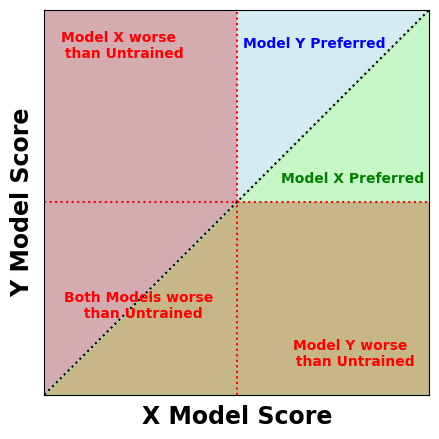

In [29]:


fig, ax = plt.subplots(figsize=(5, 5))
x = np.linspace(-10, 10, 400)
y = np.linspace(-10, 10, 400)
X, Y = np.meshgrid(x, y)

quad1 = (X > 0) & (Y > 0)  
not_quad1 = ~quad1
ax.contourf(X, Y, not_quad1, levels=[0.5, 1], colors=['red'], alpha=0.5)

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)

ax.axhline(0, color='red', linestyle='dotted')
ax.axvline(0, color='red', linestyle='dotted')

ax.plot(x, x, color='black', linestyle='dotted')

ax.fill_between(x, x, 10, where=(x <= 10), color='lightblue', alpha=0.5)
ax.fill_between(x, x, -10, where=(x >= -10), color='lightgreen', alpha=0.5)

ax.set_xticks([])
ax.set_yticks([])

ax.set_aspect('equal', adjustable='box')

ax.annotate('Model X worse \n than Untrained', xy=(-6, 4), xytext=(-6, 7.5),weight='bold',
            fontsize=10, ha='center', color='red')

ax.annotate('Model Y worse \n than Untrained', xy=(-6, 4), xytext=(6, -8.5),weight='bold',
            fontsize=10, ha='center', color='red')

ax.annotate('Both Models worse \n than Untrained', xy=(-6, 4), xytext=(-5, -6),weight='bold',
            fontsize=10, ha='center', color='red')

ax.annotate('Model X Preferred', xy=(-6, 4), xytext=(6, 1),weight='bold',
            fontsize=10, ha='center', color='green')
ax.annotate('Model Y Preferred', xy=(-6, 4), xytext=(4, 8),weight='bold',
            fontsize=10, ha='center', color='blue')

plt.xlabel('X Model Score', fontweight='bold', fontsize=17)
plt.ylabel('Y Model Score', fontweight='bold', fontsize=17)

plt.show()


## IPCL

In [30]:
tempscores = pd.DataFrame(columns = ['Dataset','Brain Area','Model','Metric','Score','Err'])
path='results/ipcl_comparison/'
models=os.listdir(path)
for j in models:
    for k in os.listdir(path+j):
        if 'NSD' not in k and 'SRP' not in k:
            for l in METRICS:
                temp=np.load(path+j+'/'+k,allow_pickle=True)[()]
                if l=='Procrustes' or l=='SoftMatching':
                    scale=-1
                else:
                    scale=1
                temp=temp[l]
                temp['Score']=scale*temp['Score']
                scores = temp.groupby('Layer', sort=False)['Score'].agg(['mean', 'sem'])
                max_row = scores.loc[scores['mean'].idxmax()]  # row with the best layer
                best_score = max_row['mean']
                best_sem   = max_row['sem']


                tempscores.loc[len(tempscores)]={'Dataset':k.split('_')[0],'Brain Area': k.split('_')[1],'Model':j.split('_')[-1],'Metric':l,'Score':best_score,'Err':best_sem}
            



In [31]:
def errcombiner(x,y):
    return np.sqrt(float(x)**2+float(y)**2)

In [32]:
SelfSupervisedLearning = pd.DataFrame(columns = ['Dataset','Brain Area','Model','Metric','Score','Err'])

for dataset in ['ObjectOrientation','InanimateObjects']:
    for area in ['EarlyV','pOTC','aOTC']:
        for i in METRICS:
            random=tempscores.loc[(tempscores['Model'] == 'random') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Score']
            cat=tempscores.loc[(tempscores['Model'] == 'category') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Score']
            selfsup=tempscores.loc[(tempscores['Model'] == 'ipcl') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Score']
            
            randomerr=tempscores.loc[(tempscores['Model'] == 'random') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Err']
            caterr=tempscores.loc[(tempscores['Model'] == 'category') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Err']
            selfsuperr=tempscores.loc[(tempscores['Model'] == 'ipcl') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Err']
            
            SelfSupervisedLearning.loc[len(SelfSupervisedLearning)]={'Dataset':dataset,'Brain Area': area,'Model':'Self-Supervised','Metric':i,'Score':float(selfsup)-float(random),'Err':errcombiner(selfsuperr,randomerr)}
            SelfSupervisedLearning.loc[len(SelfSupervisedLearning)]={'Dataset':dataset,'Brain Area': area,'Model':'Category-Supervised','Metric':i,'Score':float(cat)-float(random),'Err':errcombiner(caterr,randomerr)}

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


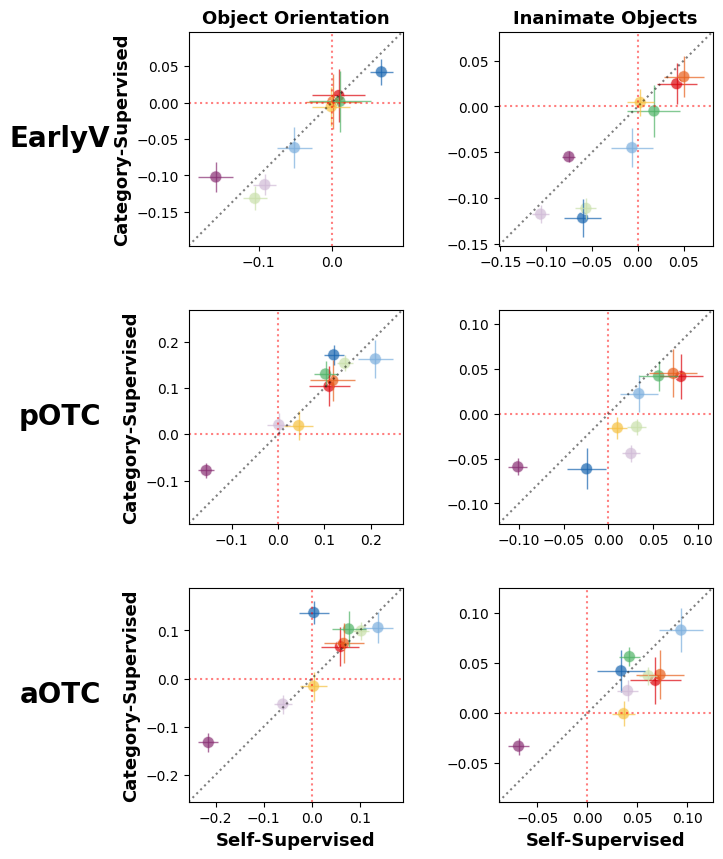

In [ ]:


fig, axes = plt.subplots(3, 2, figsize=(8, 10)) 
axes = axes.flatten()

legend_handles = {}
idx = 0
for i in ['ObjectOrientation', 'InanimateObjects']:
    for j in ['EarlyV', 'pOTC', 'aOTC']:
        if idx < 3:
            ax = axes[idx * 2]  
        else:
            ax = axes[(idx - 3) * 2 + 1] 
        data_ss = SelfSupervisedLearning.loc[
            (SelfSupervisedLearning['Dataset'] == i) & 
            (SelfSupervisedLearning['Brain Area'] == j) & 
            (SelfSupervisedLearning['Model'] == 'Self-Supervised')
        ]
        data_cs = SelfSupervisedLearning.loc[
            (SelfSupervisedLearning['Dataset'] == i) & 
            (SelfSupervisedLearning['Brain Area'] == j) & 
            (SelfSupervisedLearning['Model'] == 'Category-Supervised')
        ]
        
        data_merged = pd.merge(
            data_ss[['Metric', 'Score','Err']], 
            data_cs[['Metric', 'Score','Err']], 
            on='Metric', 
            suffixes=('_ss', '_cs')
        )
        
        for row in data_merged.itertuples():
            ax.errorbar(
                x=row.Score_ss,
                y=row.Score_cs,
                xerr=row.Err_ss,      
                yerr=row.Err_cs,      
                fmt='none',           
                ecolor=METRICCOLORS[row.Metric],
                elinewidth=1,
                alpha=0.7
            )

        scatter = sns.scatterplot(
            x='Score_ss', 
            y='Score_cs', 
            hue='Metric',
            data=data_merged, 
            ax=ax, 
            s=75,
            alpha=0.7,  
            palette=METRICCOLORS,
            legend=False
        )
        
        

        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_xlim(np.min([xmin, ymin]), np.max([xmax, ymax]))
        ax.set_ylim(np.min([xmin, ymin]), np.max([xmax, ymax]))
        

        ax.set_aspect('equal', 'box')
        ax.axhline(0, color='red', linestyle='dotted',alpha=.5)  
        ax.axvline(0, color='red', linestyle='dotted',alpha=.5)  
        ax.axline((0, 0), slope=1, color='black', linestyle='dotted',alpha=.5)


        
        

        if idx < 3:
            ax = axes[idx * 2]  
        else:
            ax = axes[(idx - 3) * 2 + 1] 
        if idx < 3:
            ax.annotate(j, xy=(-0.6, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=20, rotation=0, fontweight='bold')

        ax.legend().remove()
        if idx != 2 and idx != 5:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Self-Supervised', fontweight='bold', fontsize=13)

        if idx < 3:
            ax.set_ylabel('Category-Supervised', fontweight='bold', fontsize=13)
        else:
            ax.set_ylabel('')
        if idx == 0:
            ax.set_title('Object Orientation', fontweight='bold', fontsize=13)
        elif idx == 3:
            ax.set_title('Inanimate Objects', fontweight='bold', fontsize=13)
        else:
            ax.set_title('')
        idx += 1

plt.subplots_adjust(wspace=0, hspace=0.3)

plt.show()




## Language

In [34]:
tempscores = pd.DataFrame(columns = ['Dataset','Brain Area','Model','Metric','Score','Err'])
path='results/language_comparison/'
models=os.listdir(path)
for j in models:
    for k in os.listdir(path+j):
        for l in METRICS:
            temp=np.load(path+j+'/'+k,allow_pickle=True)[()]
            if l=='Procrustes' or l=='SoftMatching':
                scale=-1
            else:
                scale=1

            temp=temp[l]
            temp['Score']=scale*temp['Score']
            scores = temp.groupby('Layer', sort=False)['Score'].agg(['mean', 'sem'])
            max_row = scores.loc[scores['mean'].idxmax()]  # row with the best layer
            best_score = max_row['mean']
            best_sem   = max_row['sem']



            tempscores.loc[len(tempscores)]={'Dataset':k.split('_')[-2],'Brain Area': k.split('_')[1],'Model':j.split('_')[-2],'Metric':l,'Score':best_score,'Err':best_sem}

In [35]:

            
SelfSupervisedLearning = pd.DataFrame(columns = ['Dataset','Brain Area','Model','Metric','Score','Err'])

for dataset in ['515','1000']:
    for area in ['V1','V2','V4','VVS','DVD','LVD']:
        for i in METRICS:
            random=tempscores.loc[(tempscores['Model'] == 'untrained') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Score']
            simclr=tempscores.loc[(tempscores['Model'] == 'simclr') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Score']
            clip=tempscores.loc[(tempscores['Model'] == 'clip') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Score']
            slip=tempscores.loc[(tempscores['Model'] == 'slip') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Score']
            
            randomerr=tempscores.loc[(tempscores['Model'] == 'untrained') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Err']
            simclrerr=tempscores.loc[(tempscores['Model'] == 'simclr') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Err']
            cliperr=tempscores.loc[(tempscores['Model'] == 'clip') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Err']
            sliperr=tempscores.loc[(tempscores['Model'] == 'slip') & (tempscores['Dataset'] == dataset) & (tempscores['Brain Area'] == area) & (tempscores['Metric'] == i)]['Err']
            tempmax=np.max([float(clip),float(slip)])
            tempmaxerr=[float(cliperr),float(sliperr)][np.argmax([float(clip),float(slip)])]
            SelfSupervisedLearning.loc[len(SelfSupervisedLearning)]={'Dataset':dataset,'Brain Area': area,'Model':'Image-Only','Metric':i,'Score':float(simclr)-float(random),'Err':errcombiner(simclrerr,randomerr)}
            SelfSupervisedLearning.loc[len(SelfSupervisedLearning)]={'Dataset':dataset,'Brain Area': area,'Model':'Language-Supervised','Metric':i,'Score':tempmax-float(random),'Err':errcombiner(tempmaxerr,randomerr)}


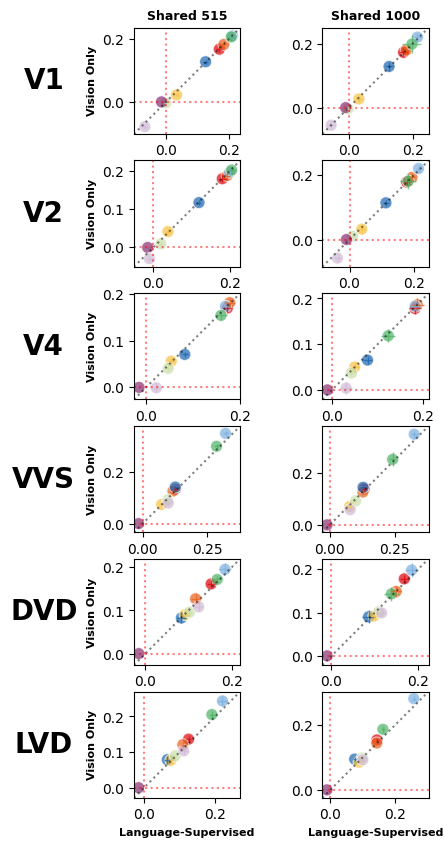

In [ ]:


fig, axes = plt.subplots(6, 2, figsize=(9, 10)) 
axes = axes.flatten()

legend_handles = {}
idx = 0
for i in ['515','1000']:
    for j in ['V1','V2','V4','VVS','DVD','LVD']:
        if idx < 6:
            ax = axes[idx * 2]  
        else:
            ax = axes[(idx - 6) * 2 + 1]  
        data_ss = SelfSupervisedLearning.loc[
            (SelfSupervisedLearning['Dataset'] == i) & 
            (SelfSupervisedLearning['Brain Area'] == j) & 
            (SelfSupervisedLearning['Model'] == 'Image-Only')
        ]
        data_cs = SelfSupervisedLearning.loc[
            (SelfSupervisedLearning['Dataset'] == i) & 
            (SelfSupervisedLearning['Brain Area'] == j) & 
            (SelfSupervisedLearning['Model'] == 'Language-Supervised')
        ]
        
        data_merged = pd.merge(
            data_ss[['Metric', 'Score','Err']], 
            data_cs[['Metric', 'Score','Err']], 
            on='Metric', 
            suffixes=('_ss', '_cs')
        )

        for row in data_merged.itertuples():
            ax.errorbar(
                x=row.Score_ss,
                y=row.Score_cs,
                xerr=row.Err_ss,      
                yerr=row.Err_cs,      
                fmt='none',           
                ecolor=METRICCOLORS[row.Metric],
                elinewidth=1,
                alpha=0.7
            )

        scatter = sns.scatterplot(
            x='Score_ss', 
            y='Score_cs', 
            hue='Metric',
            data=data_merged, 
            ax=ax, 
            s=75,
            alpha=0.7,  
            palette=METRICCOLORS,
            legend=False
        )
        xmin, xmax = ax.get_xlim()
        ymin, ymax = ax.get_ylim()
        ax.set_xlim(np.min([xmin, ymin]), np.max([xmax, ymax]))
        ax.set_ylim(np.min([xmin, ymin]), np.max([xmax, ymax]))
        
        if not legend_handles:
            handles, labels = scatter.get_legend_handles_labels()
            for handle, label in zip(handles, labels):
                if label not in legend_handles:
                    legend_handles[label] = handle
        

        

        ax.set_aspect('equal', 'box')
        ax.axline((0, 0), slope=1, color='black', linestyle='dotted',alpha=.5)
        ax.axhline(0, color='red', linestyle='dotted',alpha=.5)  
        ax.axvline(0, color='red', linestyle='dotted',alpha=.5)  

        
        if idx != 5 and idx != 11:
            ax.set_xlabel('')
        else:
            ax.set_xlabel('Language-Supervised', fontweight='bold', fontsize=8)

        if idx < 6:
            ax.set_ylabel('Vision Only', fontweight='bold', fontsize=8)
        else:
            ax.set_ylabel('')
        if idx == 0:
            ax.set_title('Shared 515', fontweight='bold', fontsize=9)
        elif idx == 6:
            ax.set_title('Shared 1000', fontweight='bold', fontsize=9)
        else:
            ax.set_title('')

        
        if idx < 6:
            ax.annotate(j, xy=(-0.85, 0.5), xycoords='axes fraction', ha='center', va='center', fontsize=20, rotation=0, fontweight='bold')
        idx += 1


plt.subplots_adjust(wspace=-0.63, hspace=0.25)

plt.show()





## TDANN

In [37]:
tempscores = pd.DataFrame(columns = ['Level','Model','Metric','Score','Err'])
path='results/TDANN/'
models=os.listdir(path)
spatlevels=[0.1,0.25,0.5,1.25,2.5,25,0.01]
for j in models:
    for l in METRICS:
        temp=np.load(path+j+'/NSD_VVS_515_None.npy',allow_pickle=True)[()]
        if l=='Procrustes' or l=='SoftMatching':
            scale=-1
        else:
            scale=1

        temp=temp[l]
        temp['Score']=scale*temp['Score']
        scores = temp.groupby('Layer', sort=False)['Score'].agg(['mean', 'sem'])
        max_row = scores.loc[scores['mean'].idxmax()]  # row with the best layer
        best_score = max_row['mean']
        best_sem   = max_row['sem']



        tempscores.loc[len(tempscores)]={'Level':spatlevels[int(j.split('_')[-1])],'Model':j.split('_')[-2],'Metric':l,'Score':best_score,'Err':best_sem}


minandmaxTDANN= np.load('results/minandmax/NSD_VVS_515_None.npy',allow_pickle=True)[()]

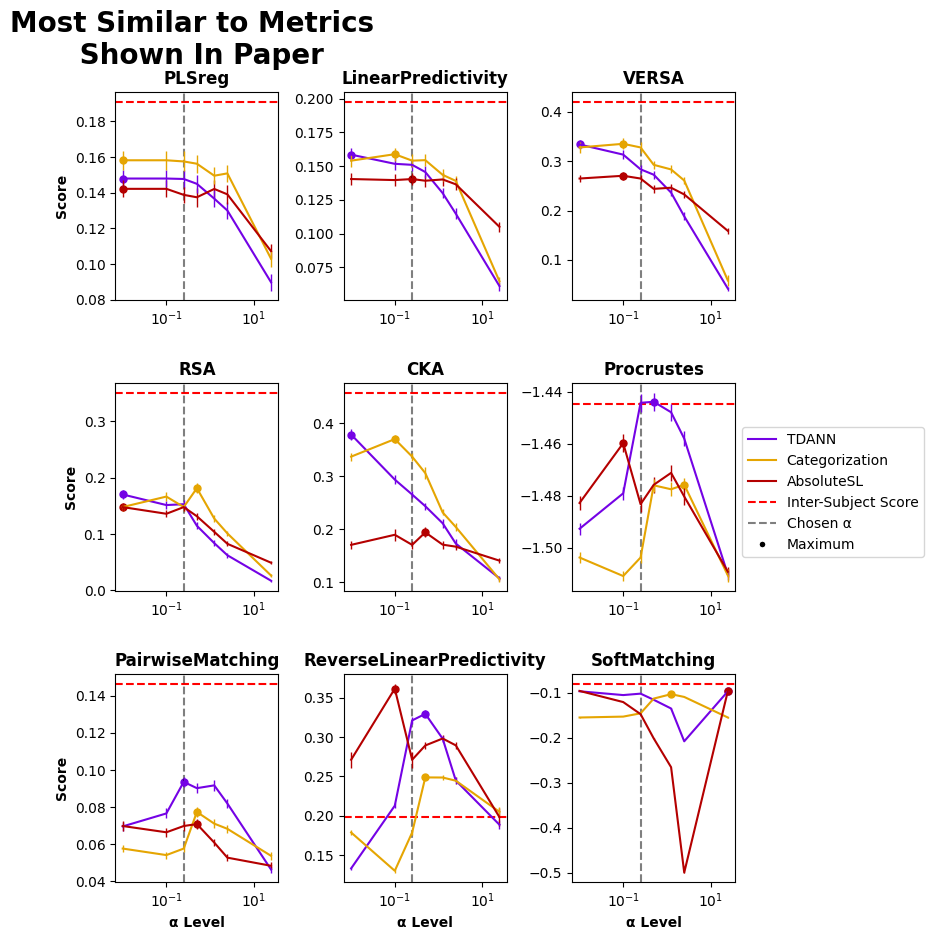

In [ ]:


fig, axes = plt.subplots(3, 3, figsize=(8, 10))
axes = axes.flatten()

legend_handles = {}
idx = 0


model_to_color = {'Categorization': "#E5A502",'TDANN': "#7402E5",'AbsoluteSL': "#B40000"}

for i in ['PLSreg','LinearPredictivity','VERSA','RSA','CKA','Procrustes','PairwiseMatching','ReverseLinearPredictivity','SoftMatching']:
    ax = axes[idx]
    temp = tempscores.loc[(tempscores['Metric'] == i)].sort_values(by='Level')
    ax.set(xscale="log")
    
    
    if i == 'Procrustes' or i=='SoftMatching':
        scale = -1
    else:
        scale = 1
    max1 = scale * np.mean(minandmaxTDANN[i][0])
    ax.axhline(max1, linestyle='--', color='red')  

    for model in temp['Model'].unique():
        model_data = temp[temp['Model'] == model]
        max_point = model_data.loc[model_data['Score'].idxmax()]
        ax.plot(max_point['Level'], max_point['Score'], 'o', color=model_to_color[model], markersize=5)
    ax.axvline(0.25, linestyle='--', color='black', alpha=0.5)
    
    for row in temp.itertuples():
        ax.errorbar(
            x=row.Level,
            y=row.Score,
            yerr=row.Err,      
            fmt='none',           
            ecolor=model_to_color[row.Model],
            elinewidth=1,
            alpha=1
        )

    scatter = sns.lineplot(
        x='Level',
        y='Score',
        hue='Model',
        data=temp,
        ax=ax,
        palette=model_to_color,
        legend='full'
    )
    ax.legend().remove()
    if idx%3!=0:
        ax.set_ylabel('')
    else:
        ax.set_ylabel('Score', fontweight='bold', fontsize=10)
    if idx>=6:
        ax.set_xlabel('α Level', fontweight='bold', fontsize=10)
    else:
        ax.set_xlabel('')
    ax.set_title(i, fontweight='bold', fontsize=12)
    if idx == 1:
        ax.annotate('Most Similar to Metrics \n Shown In Paper', xy=(-0.9, 1.25), xycoords='axes fraction', ha='center', va='center', fontsize=20, rotation=0, fontweight='bold')
    idx += 1

handles, labels = ax.get_legend_handles_labels()

custom_lines = [
    Line2D([0], [0], color='red', linestyle='--'),
    Line2D([0], [0], color='black', linestyle='--', alpha=0.5),
    Line2D([0], [0], marker='o', color='w', markerfacecolor='black', markersize=5) 
]

        

handles.extend(custom_lines)
labels.extend(['Inter-Subject Score', 'Chosen α', 'Maximum'])



fig.legend(handles=handles, labels=labels, loc='center left', bbox_to_anchor=(0.9, 0.5))

plt.subplots_adjust(wspace=0.4, hspace=0.4, top=0.9)
plt.show()
